In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/retail/retail_data.csv
/kaggle/input/good-dataset/good_data.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

class LoyaltyPointsEDA:
    def __init__(self, df):
        """Initialize with transaction dataframe"""
        self.df = df.copy()
        self.cleaned_df = None
        self.customer_summary = None
        
    def initial_exploration(self):
        """Perform initial data exploration"""
        print("="*80)
        print("INITIAL DATA EXPLORATION")
        print("="*80)
        
        print(f"\nDataset Shape: {self.df.shape}")
        print(f"\nColumns: {list(self.df.columns)}")
        
        print("\n" + "-"*80)
        print("Data Types:")
        print("-"*80)
        print(self.df.dtypes)
        
        print("\n" + "-"*80)
        print("First Few Rows:")
        print("-"*80)
        print(self.df.head())
        
        print("\n" + "-"*80)
        print("Statistical Summary:")
        print("-"*80)
        print(self.df.describe())
        
        print("\n" + "-"*80)
        print("Missing Values:")
        print("-"*80)
        missing = self.df.isnull().sum()
        missing_pct = (missing / len(self.df)) * 100
        missing_df = pd.DataFrame({
            'Missing_Count': missing,
            'Percentage': missing_pct
        })
        print(missing_df[missing_df['Missing_Count'] > 0])
        
        print("\n" + "-"*80)
        print("Duplicate Rows:")
        print("-"*80)
        print(f"Number of duplicates: {self.df.duplicated().sum()}")
        
    def clean_data(self):
        """Clean and preprocess the data"""
        print("\n" + "="*80)
        print("DATA CLEANING")
        print("="*80)
        
        df_clean = self.df.copy()
        
        # 1. Handle missing values
        print("\n1. Handling Missing Values...")
        for col in df_clean.columns:
            if df_clean[col].isnull().sum() > 0:
                if df_clean[col].dtype in ['float64', 'int64']:
                    df_clean[col].fillna(df_clean[col].median(), inplace=True)
                    print(f"   - Filled {col} with median")
                else:
                    df_clean[col].fillna('Unknown', inplace=True)
                    print(f"   - Filled {col} with 'Unknown'")
        
        # 2. Remove duplicates
        print("\n2. Removing Duplicates...")
        before = len(df_clean)
        df_clean.drop_duplicates(inplace=True)
        after = len(df_clean)
        print(f"   - Removed {before - after} duplicate rows")
        
        # 3. Convert date columns
        print("\n3. Converting Date Columns...")
        date_cols = [col for col in df_clean.columns if 'date' in col.lower() or 'time' in col.lower()]
        for col in date_cols:
            try:
                df_clean[col] = pd.to_datetime(df_clean[col])
                print(f"   - Converted {col} to datetime")
            except:
                print(f"   - Could not convert {col}")
        
        # 4. Handle outliers in numeric columns
        print("\n4. Detecting Outliers (IQR method)...")
        numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            outliers = ((df_clean[col] < (Q1 - 1.5 * IQR)) | (df_clean[col] > (Q3 + 1.5 * IQR))).sum()
            if outliers > 0:
                print(f"   - {col}: {outliers} outliers detected ({outliers/len(df_clean)*100:.2f}%)")
        
        self.cleaned_df = df_clean
        print("\nData cleaning completed!")
        return df_clean
    
    def visualize_data(self):
        """Create visualizations for EDA"""
        if self.cleaned_df is None:
            print("Please run clean_data() first!")
            return
        
        print("\n" + "="*80)
        print("DATA VISUALIZATIONS")
        print("="*80)
        
        df = self.cleaned_df
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        
        # Distribution plots
        if len(numeric_cols) > 0:
            fig, axes = plt.subplots(min(len(numeric_cols), 3), 1, figsize=(12, 4*min(len(numeric_cols), 3)))
            if len(numeric_cols) == 1:
                axes = [axes]
            
            for i, col in enumerate(numeric_cols[:3]):
                df[col].hist(bins=30, ax=axes[i], edgecolor='black')
                axes[i].set_title(f'Distribution of {col}')
                axes[i].set_xlabel(col)
                axes[i].set_ylabel('Frequency')
            
            plt.tight_layout()
            plt.show()
        
        # Correlation heatmap
        if len(numeric_cols) > 1:
            plt.figure(figsize=(10, 8))
            sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', center=0, fmt='.2f')
            plt.title('Correlation Heatmap')
            plt.tight_layout()
            plt.show()
    
    def calculate_loyalty_points(self, transaction_amt_col, points_rate=0.1):
        """
        Calculate accrued points for current transactions
        
        Parameters:
        -----------
        transaction_amt_col : str
            Column name containing transaction amount
        points_rate : float
            Points earned per dollar (default: 0.1 = 10 points per $100)
        """
        if self.cleaned_df is None:
            print("Please run clean_data() first!")
            return
        
        print("\n" + "="*80)
        print("CALCULATING LOYALTY POINTS")
        print("="*80)
        
        df = self.cleaned_df.copy()
        
        # Calculate accrued points for current transaction
        df['accrued_points'] = df[transaction_amt_col] * points_rate
        df['accrued_points'] = df['accrued_points'].round(2)
        
        print(f"\nPoints Rate: {points_rate} points per dollar")
        print(f"Total Points Accrued: {df['accrued_points'].sum():,.2f}")
        print(f"Average Points per Transaction: {df['accrued_points'].mean():,.2f}")
        
        self.cleaned_df = df
        return df
    
    def update_customer_balance(self, customer_id_col, initial_balance=0):
        """
        Update customer's total point balance
        
        Parameters:
        -----------
        customer_id_col : str
            Column name containing customer ID
        initial_balance : float
            Initial balance for new customers
        """
        if self.cleaned_df is None or 'accrued_points' not in self.cleaned_df.columns:
            print("Please run calculate_loyalty_points() first!")
            return
        
        print("\n" + "="*80)
        print("UPDATING CUSTOMER POINT BALANCES")
        print("="*80)
        
        df = self.cleaned_df.copy()
        
        # Calculate cumulative points per customer
        customer_points = df.groupby(customer_id_col).agg({
            'accrued_points': 'sum'
        }).reset_index()
        
        customer_points.rename(columns={'accrued_points': 'total_point_balance'}, inplace=True)
        customer_points['total_point_balance'] += initial_balance
        
        # Merge back to main dataframe
        df = df.merge(customer_points, on=customer_id_col, how='left')
        
        print(f"\nTotal Customers: {df[customer_id_col].nunique()}")
        print(f"Total Points Distributed: {customer_points['total_point_balance'].sum():,.2f}")
        print(f"Average Balance per Customer: {customer_points['total_point_balance'].mean():,.2f}")
        print(f"Top Customer Balance: {customer_points['total_point_balance'].max():,.2f}")
        
        self.cleaned_df = df
        self.customer_summary = customer_points
        return df, customer_points
    
    def calculate_rfm(self, customer_id_col, date_col, transaction_amt_col, reference_date=None):
        """
        Calculate RFM (Recency, Frequency, Monetary) metrics
        
        Parameters:
        -----------
        customer_id_col : str
            Column name containing customer ID
        date_col : str
            Column name containing transaction date
        transaction_amt_col : str
            Column name containing transaction amount
        reference_date : datetime
            Reference date for recency calculation (default: max date in data)
        """
        if self.cleaned_df is None:
            print("Please run clean_data() first!")
            return
        
        print("\n" + "="*80)
        print("CALCULATING RFM METRICS")
        print("="*80)
        
        df = self.cleaned_df.copy()
        
        # Set reference date
        if reference_date is None:
            reference_date = df[date_col].max()
        
        # Calculate RFM metrics
        rfm = df.groupby(customer_id_col).agg({
            date_col: lambda x: (reference_date - x.max()).days,  # Recency
            customer_id_col: 'count',  # Frequency
            transaction_amt_col: 'sum'  # Monetary
        }).reset_index()
        
        rfm.columns = [customer_id_col, 'recency', 'frequency', 'monetary']
        
        # Calculate RFM scores (1-5, where 5 is best)
        rfm['R_score'] = pd.qcut(rfm['recency'], 5, labels=[5,4,3,2,1], duplicates='drop')
        rfm['F_score'] = pd.qcut(rfm['frequency'].rank(method='first'), 5, labels=[1,2,3,4,5], duplicates='drop')
        rfm['M_score'] = pd.qcut(rfm['monetary'], 5, labels=[1,2,3,4,5], duplicates='drop')
        
        # Convert to numeric
        rfm['R_score'] = rfm['R_score'].astype(int)
        rfm['F_score'] = rfm['F_score'].astype(int)
        rfm['M_score'] = rfm['M_score'].astype(int)
        
        # Calculate RFM composite score
        rfm['RFM_score'] = rfm['R_score'] + rfm['F_score'] + rfm['M_score']
        
        # Segment customers
        rfm['customer_segment'] = rfm['RFM_score'].apply(self._segment_customer)
        
        # Add to cleaned dataframe
        self.cleaned_df = df.merge(rfm[[customer_id_col, 'recency', 'frequency', 'monetary', 
                                         'R_score', 'F_score', 'M_score', 'RFM_score', 
                                         'customer_segment']], on=customer_id_col, how='left')
        
        print(f"\nRFM Analysis Summary:")
        print(f"Reference Date: {reference_date.strftime('%Y-%m-%d')}")
        print(f"\nRecency (days since last purchase):")
        print(f"  - Mean: {rfm['recency'].mean():.1f} days")
        print(f"  - Median: {rfm['recency'].median():.1f} days")
        print(f"\nFrequency (number of purchases):")
        print(f"  - Mean: {rfm['frequency'].mean():.1f} transactions")
        print(f"  - Median: {rfm['frequency'].median():.1f} transactions")
        print(f"\nMonetary (total spend):")
        print(f"  - Mean: ${rfm['monetary'].mean():,.2f}")
        print(f"  - Median: ${rfm['monetary'].median():,.2f}")
        
        print("\n" + "-"*80)
        print("Customer Segmentation:")
        print("-"*80)
        print(rfm['customer_segment'].value_counts().sort_index())
        
        return self.cleaned_df, rfm
    
    def _segment_customer(self, score):
        """Segment customers based on RFM score"""
        if score >= 13:
            return 'Champions'
        elif score >= 10:
            return 'Loyal Customers'
        elif score >= 7:
            return 'Potential Loyalists'
        elif score >= 5:
            return 'At Risk'
        else:
            return 'Lost'
    
    def generate_report(self):
        """Generate comprehensive summary report"""
        if self.cleaned_df is None:
            print("Please complete the analysis pipeline first!")
            return
        
        print("\n" + "="*80)
        print("COMPREHENSIVE LOYALTY PROGRAM REPORT")
        print("="*80)
        
        df = self.cleaned_df
        
        print("\n📊 DATASET OVERVIEW")
        print(f"  - Total Transactions: {len(df):,}")
        print(f"  - Date Range: {df[df.select_dtypes(include=['datetime64']).columns[0]].min().strftime('%Y-%m-%d')} to {df[df.select_dtypes(include=['datetime64']).columns[0]].max().strftime('%Y-%m-%d')}")
        
        if 'accrued_points' in df.columns:
            print("\n💎 POINTS SUMMARY")
            print(f"  - Total Points Accrued: {df['accrued_points'].sum():,.2f}")
            print(f"  - Average Points per Transaction: {df['accrued_points'].mean():,.2f}")
        
        if 'total_point_balance' in df.columns:
            print("\n👥 CUSTOMER BALANCES")
            print(f"  - Total Customers: {df[df.columns[0]].nunique():,}")
            print(f"  - Average Balance: {df.groupby(df.columns[0])['total_point_balance'].first().mean():,.2f}")
        
        if 'customer_segment' in df.columns:
            print("\n🎯 CUSTOMER SEGMENTS")
            segments = df.groupby(df.columns[0])['customer_segment'].first().value_counts()
            for segment, count in segments.items():
                print(f"  - {segment}: {count} ({count/len(segments)*100:.1f}%)")
        
        print("\n" + "="*80)


def run_loyalty_analysis(file_path, 
                         customer_id_col='customer_id',
                         date_col='transaction_date', 
                         transaction_amt_col='amount',
                         points_rate=0.1,
                         initial_balance=0,
                         output_folder='output'):
    """
    Complete loyalty points analysis pipeline
    
    Parameters:
    -----------
    file_path : str
        Path to CSV file containing transaction data
    customer_id_col : str
        Column name for customer ID
    date_col : str
        Column name for transaction date
    transaction_amt_col : str
        Column name for transaction amount
    points_rate : float
        Points earned per dollar (default: 0.1)
    initial_balance : float
        Initial balance for customers
    output_folder : str
        Folder to save output files
    
    Returns:
    --------
    df_final : DataFrame
        Cleaned data with all calculations
    rfm_df : DataFrame
        RFM analysis summary
    customer_summary : DataFrame
        Customer point balances
    """
    import os
    
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
    
    print("\n" + "🚀 "*40)
    print("LOYALTY POINTS ANALYSIS PIPELINE")
    print("🚀 "*40)
    
    # Step 1: Load data
    print("\n📁 Loading data from:", file_path)
    try:
        df = pd.read_csv(file_path)
        print(f"✅ Successfully loaded {len(df):,} rows and {len(df.columns)} columns")
    except Exception as e:
        print(f"❌ Error loading file: {e}")
        return None, None, None
    
    # Step 2: Initialize EDA object
    print("\n🔧 Initializing analysis...")
    eda = LoyaltyPointsEDA(df)
    
    # Step 3: Explore data
    eda.initial_exploration()
    
    # Step 4: Clean data
    df_clean = eda.clean_data()
    
    # Step 5: Visualize (optional - comment out if not needed)
    try:
        eda.visualize_data()
    except:
        print("⚠️ Skipping visualizations")
    
    # Step 6: Calculate loyalty points
    eda.calculate_loyalty_points(
        transaction_amt_col=transaction_amt_col, 
        points_rate=points_rate
    )
    
    # Step 7: Update customer balances
    df_with_balance, customer_summary = eda.update_customer_balance(
        customer_id_col=customer_id_col,
        initial_balance=initial_balance
    )
    
    # Step 8: Calculate RFM
    df_final, rfm_df = eda.calculate_rfm(
        customer_id_col=customer_id_col,
        date_col=date_col,
        transaction_amt_col=transaction_amt_col
    )
    
    # Step 9: Generate report
    eda.generate_report()
    
    # Step 10: Export results
    print("\n" + "="*80)
    print("EXPORTING RESULTS")
    print("="*80)
    
    output_files = {
        'cleaned_data': os.path.join(output_folder, 'cleaned_loyalty_data.csv'),
        'rfm_analysis': os.path.join(output_folder, 'rfm_analysis.csv'),
        'customer_summary': os.path.join(output_folder, 'customer_point_balances.csv')
    }
    
    try:
        df_final.to_csv(output_files['cleaned_data'], index=False)
        print(f"✅ Cleaned data saved to: {output_files['cleaned_data']}")
        
        rfm_df.to_csv(output_files['rfm_analysis'], index=False)
        print(f"✅ RFM analysis saved to: {output_files['rfm_analysis']}")
        
        customer_summary.to_csv(output_files['customer_summary'], index=False)
        print(f"✅ Customer balances saved to: {output_files['customer_summary']}")
    except Exception as e:
        print(f"⚠️ Error saving files: {e}")
    
    print("\n" + "✨ "*40)
    print("ANALYSIS COMPLETE!")
    print("✨ "*40 + "\n")
    
    return df_final, rfm_df, customer_summary


# SIMPLE USAGE
# =============

if __name__ == "__main__":
    # Method 1: Simple - just provide file path
    df_final, rfm_df, customer_summary = run_loyalty_analysis(
        file_path='transactions.csv'
    )
    
    # Method 2: Custom configuration
    # df_final, rfm_df, customer_summary = run_loyalty_analysis(
    #     file_path='data/transactions.csv',
    #     customer_id_col='cust_id',          # Your customer ID column
    #     date_col='purchase_date',            # Your date column
    #     transaction_amt_col='total_amount',  # Your amount column
    #     points_rate=0.05,                    # 5 points per $100
    #     initial_balance=100,                 # Starting bonus points
    #     output_folder='results'              # Output folder name
    # )

EXPLORATORY DATA ANALYSIS (EDA)

📁 STEP 1: LOADING DATA
--------------------------------------------------------------------------------
✅ Successfully loaded: /kaggle/input/retail/retail_data.csv
   Rows: 302,010
   Columns: 30

📊 STEP 2: BASIC INFORMATION

🔹 Column Names:
   1. Transaction_ID
   2. Customer_ID
   3. Name
   4. Email
   5. Phone
   6. Address
   7. City
   8. State
   9. Zipcode
   10. Country
   11. Age
   12. Gender
   13. Income
   14. Customer_Segment
   15. Date
   16. Year
   17. Month
   18. Time
   19. Total_Purchases
   20. Amount
   21. Total_Amount
   22. Product_Category
   23. Product_Brand
   24. Product_Type
   25. Feedback
   26. Shipping_Method
   27. Payment_Method
   28. Order_Status
   29. Ratings
   30. products

🔹 Data Types:
Transaction_ID      float64
Customer_ID         float64
Name                 object
Email                object
Phone               float64
Address              object
City                 object
State                object


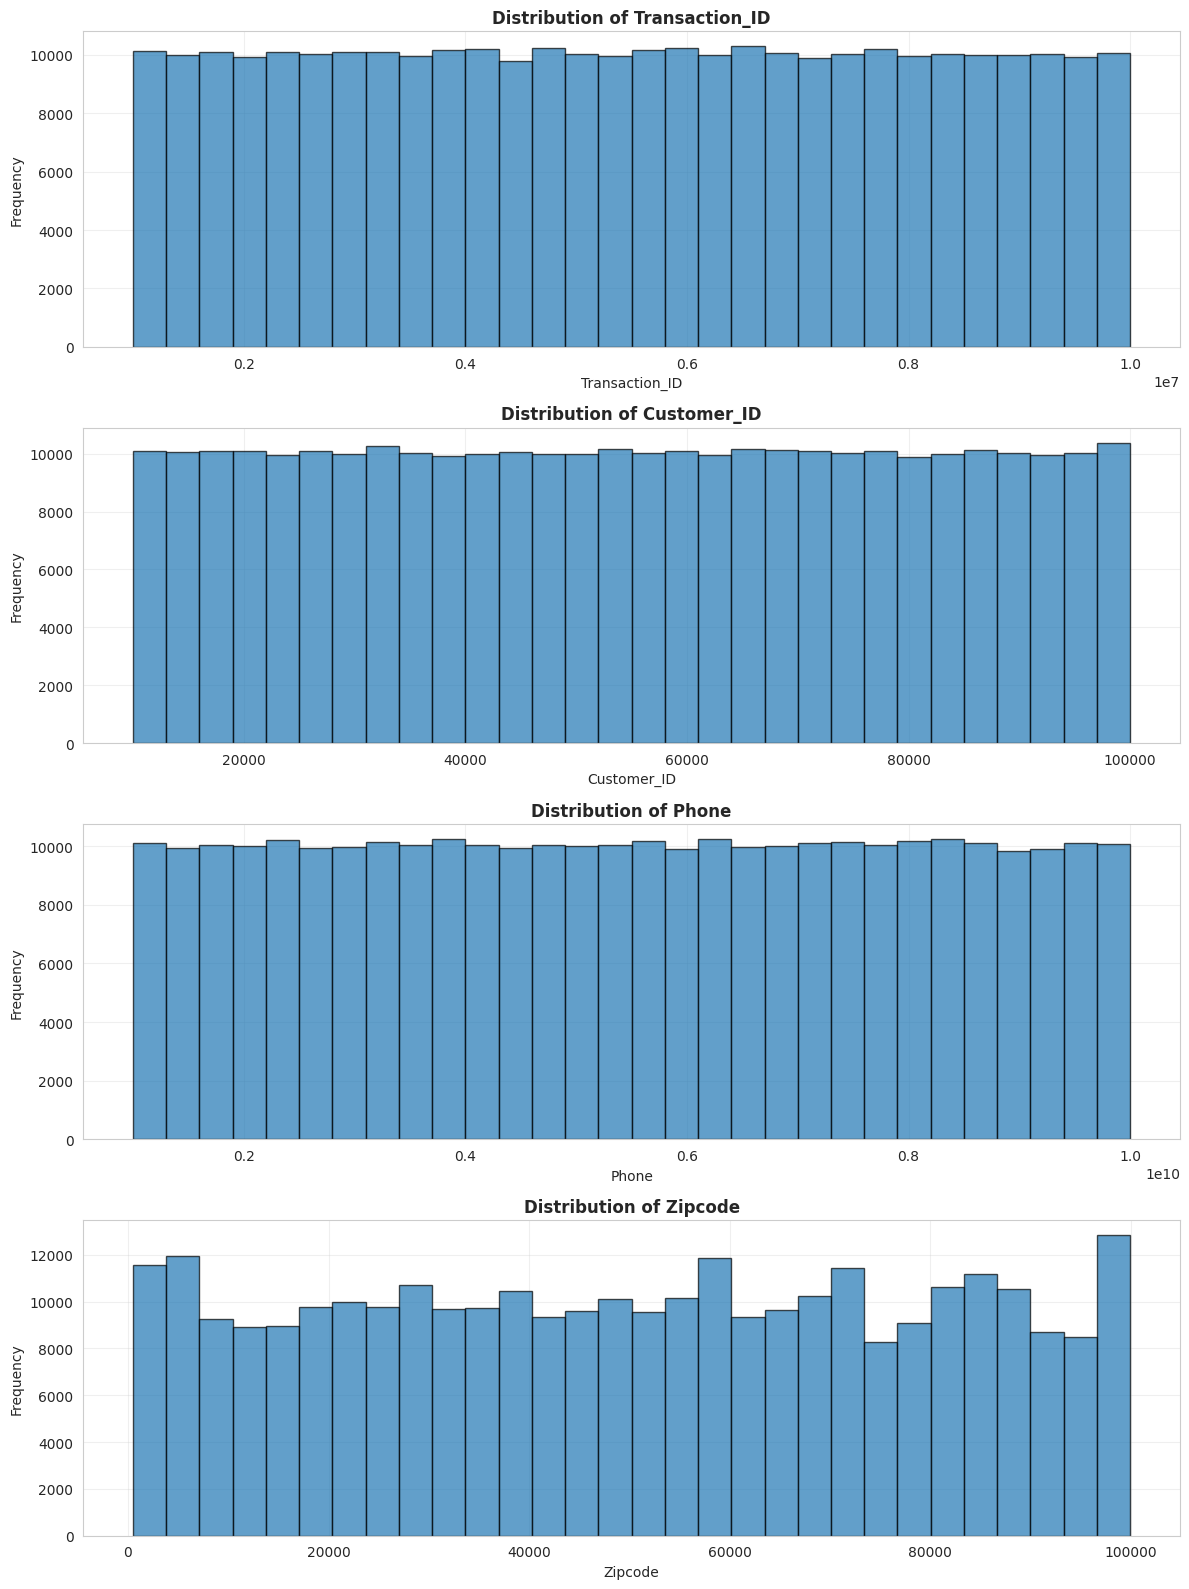

✅ Distribution plots generated


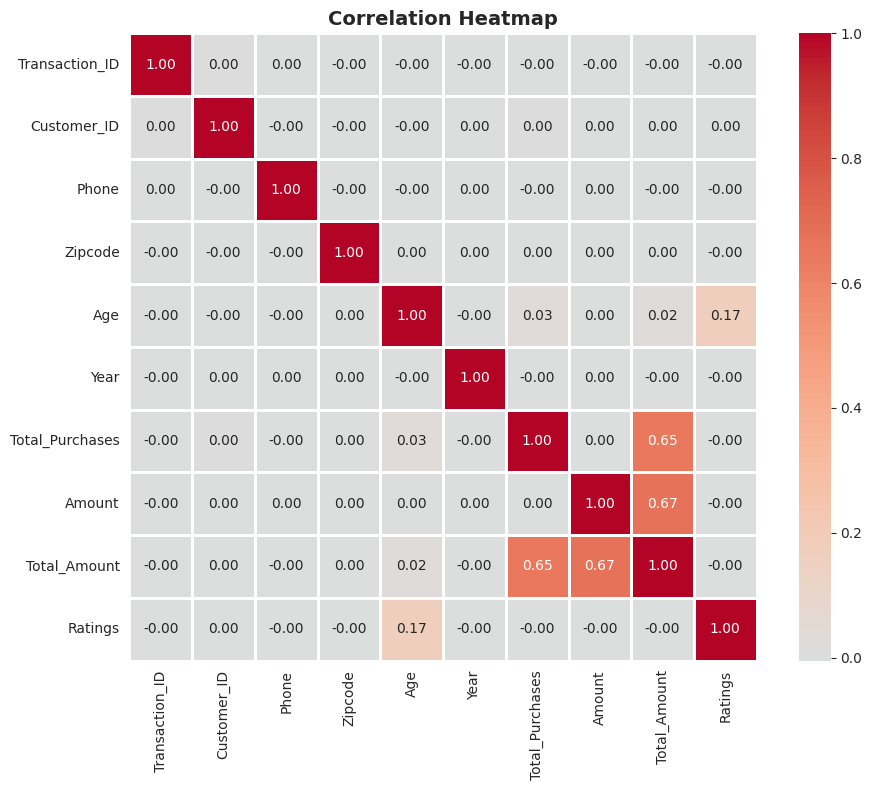

✅ Correlation heatmap generated


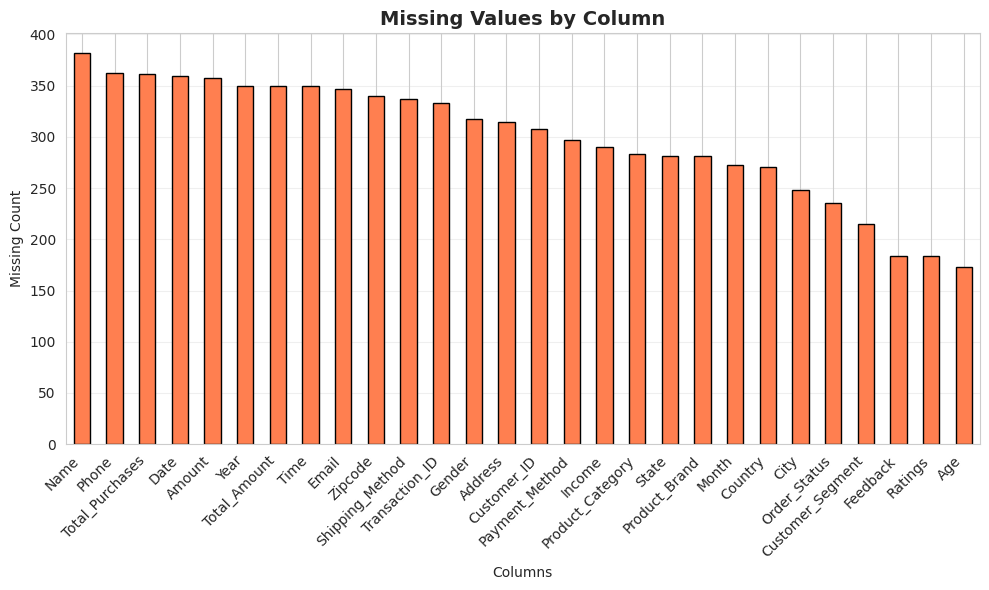

✅ Missing values chart generated

📋 STEP 12: EDA SUMMARY

✅ EDA COMPLETED SUCCESSFULLY!

📊 Key Findings:
   • Total Rows: 302,010
   • Total Columns: 30
   • Missing Values: 8,383
   • Duplicate Rows: 4
   • Numeric Columns: 10
   • Categorical Columns: 20
   • Memory Usage: 402.71 MB

💡 Next Steps:
   1. Handle missing values
   2. Remove duplicates if necessary
   3. Handle outliers
   4. Proceed with data cleaning and feature engineering
    

✅ DataFrame is ready for further analysis!


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


def perform_eda(file_path):
    """
    Perform comprehensive Exploratory Data Analysis on a dataset
    
    Parameters:
    -----------
    file_path : str
        Path to the CSV file
    
    Returns:
    --------
    df : DataFrame
        Loaded dataframe
    """
    
    print("="*80)
    print("EXPLORATORY DATA ANALYSIS (EDA)")
    print("="*80)
    
    # ========================================
    # 1. LOAD DATA
    # ========================================
    print("\n📁 STEP 1: LOADING DATA")
    print("-"*80)
    try:
        df = pd.read_csv(file_path)
        print(f"✅ Successfully loaded: {file_path}")
        print(f"   Rows: {df.shape[0]:,}")
        print(f"   Columns: {df.shape[1]}")
    except Exception as e:
        print(f"❌ Error loading file: {e}")
        return None
    
    # ========================================
    # 2. BASIC INFORMATION
    # ========================================
    print("\n" + "="*80)
    print("📊 STEP 2: BASIC INFORMATION")
    print("="*80)
    
    print("\n🔹 Column Names:")
    for i, col in enumerate(df.columns, 1):
        print(f"   {i}. {col}")
    
    print("\n🔹 Data Types:")
    print(df.dtypes)
    
    print("\n🔹 Dataset Shape:")
    print(f"   Rows: {df.shape[0]:,}")
    print(f"   Columns: {df.shape[1]}")
    print(f"   Total Cells: {df.shape[0] * df.shape[1]:,}")
    
    print("\n🔹 Memory Usage:")
    memory = df.memory_usage(deep=True).sum() / 1024**2
    print(f"   {memory:.2f} MB")
    
    # ========================================
    # 3. FIRST AND LAST ROWS
    # ========================================
    print("\n" + "="*80)
    print("👀 STEP 3: PREVIEW DATA")
    print("="*80)
    
    print("\n🔹 First 5 Rows:")
    print(df.head())
    
    print("\n🔹 Last 5 Rows:")
    print(df.tail())
    
    # ========================================
    # 4. MISSING VALUES
    # ========================================
    print("\n" + "="*80)
    print("🔍 STEP 4: MISSING VALUES ANALYSIS")
    print("="*80)
    
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'Column': missing.index,
        'Missing_Count': missing.values,
        'Percentage': missing_pct.values
    })
    missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
    
    if len(missing_df) > 0:
        print("\n⚠️ Columns with Missing Values:")
        print(missing_df.to_string(index=False))
        print(f"\nTotal missing values: {missing.sum():,}")
    else:
        print("\n✅ No missing values found!")
    
    # ========================================
    # 5. DUPLICATE ROWS
    # ========================================
    print("\n" + "="*80)
    print("🔄 STEP 5: DUPLICATE ROWS")
    print("="*80)
    
    duplicates = df.duplicated().sum()
    print(f"\nDuplicate rows: {duplicates:,} ({duplicates/len(df)*100:.2f}%)")
    
    if duplicates > 0:
        print("⚠️ Consider removing duplicates during data cleaning")
    else:
        print("✅ No duplicates found!")
    
    # ========================================
    # 6. STATISTICAL SUMMARY
    # ========================================
    print("\n" + "="*80)
    print("📈 STEP 6: STATISTICAL SUMMARY")
    print("="*80)
    
    print("\n🔹 Numeric Columns:")
    print(df.describe())
    
    print("\n🔹 Categorical Columns:")
    categorical_cols = df.select_dtypes(include=['object']).columns
    if len(categorical_cols) > 0:
        for col in categorical_cols:
            print(f"\n   {col}:")
            print(f"      Unique values: {df[col].nunique()}")
            print(f"      Most common: {df[col].mode()[0] if len(df[col].mode()) > 0 else 'N/A'}")
            if df[col].nunique() <= 10:
                print(f"      Value counts:")
                print(df[col].value_counts().head(10).to_string())
    else:
        print("   No categorical columns found")
    
    # ========================================
    # 7. DATA TYPES BREAKDOWN
    # ========================================
    print("\n" + "="*80)
    print("🏷️ STEP 7: DATA TYPES BREAKDOWN")
    print("="*80)
    
    print("\n🔹 Column Type Distribution:")
    dtype_counts = df.dtypes.value_counts()
    for dtype, count in dtype_counts.items():
        print(f"   {dtype}: {count} columns")
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    datetime_cols = df.select_dtypes(include=['datetime64']).columns.tolist()
    
    print(f"\n   Numeric columns ({len(numeric_cols)}): {numeric_cols}")
    print(f"   Categorical columns ({len(categorical_cols)}): {categorical_cols}")
    print(f"   Datetime columns ({len(datetime_cols)}): {datetime_cols}")
    
    # ========================================
    # 8. UNIQUE VALUES
    # ========================================
    print("\n" + "="*80)
    print("🔢 STEP 8: UNIQUE VALUES PER COLUMN")
    print("="*80)
    
    print("\n")
    unique_df = pd.DataFrame({
        'Column': df.columns,
        'Unique_Values': [df[col].nunique() for col in df.columns],
        'Unique_Percentage': [df[col].nunique()/len(df)*100 for col in df.columns]
    }).sort_values('Unique_Values', ascending=False)
    
    print(unique_df.to_string(index=False))
    
    # ========================================
    # 9. OUTLIERS DETECTION (IQR METHOD)
    # ========================================
    print("\n" + "="*80)
    print("📊 STEP 9: OUTLIER DETECTION")
    print("="*80)
    
    print("\n🔹 Outliers (IQR Method):")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    outlier_summary = []
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_count = len(outliers)
        outlier_pct = (outlier_count / len(df)) * 100
        
        if outlier_count > 0:
            outlier_summary.append({
                'Column': col,
                'Outliers': outlier_count,
                'Percentage': f"{outlier_pct:.2f}%",
                'Lower_Bound': f"{lower_bound:.2f}",
                'Upper_Bound': f"{upper_bound:.2f}"
            })
    
    if outlier_summary:
        outlier_df = pd.DataFrame(outlier_summary)
        print(outlier_df.to_string(index=False))
    else:
        print("   ✅ No outliers detected!")
    
    # ========================================
    # 10. CORRELATION ANALYSIS
    # ========================================
    print("\n" + "="*80)
    print("🔗 STEP 10: CORRELATION ANALYSIS")
    print("="*80)
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 1:
        print("\n🔹 Correlation Matrix:")
        corr_matrix = df[numeric_cols].corr()
        print(corr_matrix)
        
        # Find high correlations
        print("\n🔹 High Correlations (|r| > 0.7):")
        high_corr = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                if abs(corr_matrix.iloc[i, j]) > 0.7:
                    high_corr.append({
                        'Feature_1': corr_matrix.columns[i],
                        'Feature_2': corr_matrix.columns[j],
                        'Correlation': f"{corr_matrix.iloc[i, j]:.3f}"
                    })
        
        if high_corr:
            high_corr_df = pd.DataFrame(high_corr)
            print(high_corr_df.to_string(index=False))
        else:
            print("   No high correlations found")
    else:
        print("   ⚠️ Not enough numeric columns for correlation analysis")
    
    # ========================================
    # 11. VISUALIZATIONS
    # ========================================
    print("\n" + "="*80)
    print("📊 STEP 11: GENERATING VISUALIZATIONS")
    print("="*80)
    
    # Distribution plots for numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if len(numeric_cols) > 0:
        n_cols = min(len(numeric_cols), 4)
        fig, axes = plt.subplots(n_cols, 1, figsize=(12, 4*n_cols))
        if n_cols == 1:
            axes = [axes]
        
        for i, col in enumerate(numeric_cols[:4]):
            df[col].hist(bins=30, ax=axes[i], edgecolor='black', alpha=0.7)
            axes[i].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Frequency')
            axes[i].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        print("✅ Distribution plots generated")
    
    # Correlation heatmap
    if len(numeric_cols) > 1:
        plt.figure(figsize=(10, 8))
        sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', 
                    center=0, fmt='.2f', square=True, linewidths=1)
        plt.title('Correlation Heatmap', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        print("✅ Correlation heatmap generated")
    
    # Missing values visualization
    if df.isnull().sum().sum() > 0:
        plt.figure(figsize=(10, 6))
        missing_data = df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False)
        missing_data.plot(kind='bar', color='coral', edgecolor='black')
        plt.title('Missing Values by Column', fontsize=14, fontweight='bold')
        plt.xlabel('Columns')
        plt.ylabel('Missing Count')
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()
        print("✅ Missing values chart generated")
    
    # ========================================
    # 12. SUMMARY
    # ========================================
    print("\n" + "="*80)
    print("📋 STEP 12: EDA SUMMARY")
    print("="*80)
    
    print(f"""
✅ EDA COMPLETED SUCCESSFULLY!

📊 Key Findings:
   • Total Rows: {df.shape[0]:,}
   • Total Columns: {df.shape[1]}
   • Missing Values: {df.isnull().sum().sum():,}
   • Duplicate Rows: {duplicates:,}
   • Numeric Columns: {len(df.select_dtypes(include=[np.number]).columns)}
   • Categorical Columns: {len(df.select_dtypes(include=['object']).columns)}
   • Memory Usage: {memory:.2f} MB

💡 Next Steps:
   1. Handle missing values
   2. Remove duplicates if necessary
   3. Handle outliers
   4. Proceed with data cleaning and feature engineering
    """)
    
    return df


# ============================================
# USAGE
# ============================================

if __name__ == "__main__":
    # Simply provide your file path
    file_path = '/kaggle/input/retail/retail_data.csv'  # Change this to your file path
    
    # Run EDA
    df = perform_eda(file_path)
    
    # Access the dataframe for further analysis
    if df is not None:
        print("\n✅ DataFrame is ready for further analysis!")

In [ ]:
**********************Data Quality Techniques*******************************

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


def perform_eda(file_path):
    """
    Perform comprehensive Exploratory Data Analysis on a dataset
    
    Parameters:
    -----------
    file_path : str
        Path to the CSV file
    
    Returns:
    --------
    df : DataFrame
        Loaded dataframe
    """
    
    print("="*80)
    print("EXPLORATORY DATA ANALYSIS (EDA)")
    print("="*80)
    
    # ========================================
    # 1. LOAD DATA
    # ========================================
    print("\n📁 STEP 1: LOADING DATA")
    print("-"*80)
    try:
        df = pd.read_csv(file_path)
        print(f"✅ Successfully loaded: {file_path}")
        print(f"   Rows: {df.shape[0]:,}")
        print(f"   Columns: {df.shape[1]}")
    except Exception as e:
        print(f"❌ Error loading file: {e}")
        return None
    
    # ========================================
    # 2. BASIC INFORMATION
    # ========================================
    print("\n" + "="*80)
    print("📊 STEP 2: BASIC INFORMATION")
    print("="*80)
    
    print("\n🔹 Column Names:")
    for i, col in enumerate(df.columns, 1):
        print(f"   {i}. {col}")
    
    print("\n🔹 Data Types:")
    print(df.dtypes)
    
    print("\n🔹 Dataset Shape:")
    print(f"   Rows: {df.shape[0]:,}")
    print(f"   Columns: {df.shape[1]}")
    print(f"   Total Cells: {df.shape[0] * df.shape[1]:,}")
    
    print("\n🔹 Memory Usage:")
    memory = df.memory_usage(deep=True).sum() / 1024**2
    print(f"   {memory:.2f} MB")
    
    # ========================================
    # 3. FIRST AND LAST ROWS
    # ========================================
    print("\n" + "="*80)
    print("👀 STEP 3: PREVIEW DATA")
    print("="*80)
    
    print("\n🔹 First 5 Rows:")
    print(df.head())
    
    print("\n🔹 Last 5 Rows:")
    print(df.tail())
    
    # ========================================
    # 4. MISSING VALUES
    # ========================================
    print("\n" + "="*80)
    print("🔍 STEP 4: MISSING VALUES ANALYSIS")
    print("="*80)
    
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'Column': missing.index,
        'Missing_Count': missing.values,
        'Percentage': missing_pct.values
    })
    missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
    
    if len(missing_df) > 0:
        print("\n⚠️ Columns with Missing Values:")
        print(missing_df.to_string(index=False))
        print(f"\nTotal missing values: {missing.sum():,}")
    else:
        print("\n✅ No missing values found!")
    
    # ========================================
    # 5. DUPLICATE ROWS
    # ========================================
    print("\n" + "="*80)
    print("🔄 STEP 5: DUPLICATE ROWS")
    print("="*80)
    
    duplicates = df.duplicated().sum()
    print(f"\nDuplicate rows: {duplicates:,} ({duplicates/len(df)*100:.2f}%)")
    
    if duplicates > 0:
        print("⚠️ Consider removing duplicates during data cleaning")
    else:
        print("✅ No duplicates found!")
    
    # ========================================
    # 6. STATISTICAL SUMMARY
    # ========================================
    print("\n" + "="*80)
    print("📈 STEP 6: STATISTICAL SUMMARY")
    print("="*80)
    
    print("\n🔹 Numeric Columns:")
    print(df.describe())
    
    print("\n🔹 Categorical Columns:")
    categorical_cols = df.select_dtypes(include=['object']).columns
    if len(categorical_cols) > 0:
        for col in categorical_cols:
            print(f"\n   {col}:")
            print(f"      Unique values: {df[col].nunique()}")
            print(f"      Most common: {df[col].mode()[0] if len(df[col].mode()) > 0 else 'N/A'}")
            if df[col].nunique() <= 10:
                print(f"      Value counts:")
                print(df[col].value_counts().head(10).to_string())
    else:
        print("   No categorical columns found")
    
    # ========================================
    # 7. DATA TYPES BREAKDOWN
    # ========================================
    print("\n" + "="*80)
    print("🏷️ STEP 7: DATA TYPES BREAKDOWN")
    print("="*80)
    
    print("\n🔹 Column Type Distribution:")
    dtype_counts = df.dtypes.value_counts()
    for dtype, count in dtype_counts.items():
        print(f"   {dtype}: {count} columns")
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    datetime_cols = df.select_dtypes(include=['datetime64']).columns.tolist()
    
    print(f"\n   Numeric columns ({len(numeric_cols)}): {numeric_cols}")
    print(f"   Categorical columns ({len(categorical_cols)}): {categorical_cols}")
    print(f"   Datetime columns ({len(datetime_cols)}): {datetime_cols}")
    
    # ========================================
    # 8. UNIQUE VALUES
    # ========================================
    print("\n" + "="*80)
    print("🔢 STEP 8: UNIQUE VALUES PER COLUMN")
    print("="*80)
    
    print("\n")
    unique_df = pd.DataFrame({
        'Column': df.columns,
        'Unique_Values': [df[col].nunique() for col in df.columns],
        'Unique_Percentage': [df[col].nunique()/len(df)*100 for col in df.columns]
    }).sort_values('Unique_Values', ascending=False)
    
    print(unique_df.to_string(index=False))
    
    # ========================================
    # 9. OUTLIERS DETECTION (IQR METHOD)
    # ========================================
    print("\n" + "="*80)
    print("📊 STEP 9: OUTLIER DETECTION")
    print("="*80)
    
    print("\n🔹 Outliers (IQR Method):")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    outlier_summary = []
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_count = len(outliers)
        outlier_pct = (outlier_count / len(df)) * 100
        
        if outlier_count > 0:
            outlier_summary.append({
                'Column': col,
                'Outliers': outlier_count,
                'Percentage': f"{outlier_pct:.2f}%",
                'Lower_Bound': f"{lower_bound:.2f}",
                'Upper_Bound': f"{upper_bound:.2f}"
            })
    
    if outlier_summary:
        outlier_df = pd.DataFrame(outlier_summary)
        print(outlier_df.to_string(index=False))
    else:
        print("   ✅ No outliers detected!")
    
    # ========================================
    # 10. CORRELATION ANALYSIS
    # ========================================
    print("\n" + "="*80)
    print("🔗 STEP 10: CORRELATION ANALYSIS")
    print("="*80)
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 1:
        print("\n🔹 Correlation Matrix:")
        corr_matrix = df[numeric_cols].corr()
        print(corr_matrix)
        
        # Find high correlations
        print("\n🔹 High Correlations (|r| > 0.7):")
        high_corr = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                if abs(corr_matrix.iloc[i, j]) > 0.7:
                    high_corr.append({
                        'Feature_1': corr_matrix.columns[i],
                        'Feature_2': corr_matrix.columns[j],
                        'Correlation': f"{corr_matrix.iloc[i, j]:.3f}"
                    })
        
        if high_corr:
            high_corr_df = pd.DataFrame(high_corr)
            print(high_corr_df.to_string(index=False))
        else:
            print("   No high correlations found")
    else:
        print("   ⚠️ Not enough numeric columns for correlation analysis")
    
    # ========================================
    # 11. VISUALIZATIONS
    # ========================================
    print("\n" + "="*80)
    print("📊 STEP 11: GENERATING VISUALIZATIONS")
    print("="*80)
    
    # Distribution plots for numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if len(numeric_cols) > 0:
        n_cols = min(len(numeric_cols), 4)
        fig, axes = plt.subplots(n_cols, 1, figsize=(12, 4*n_cols))
        if n_cols == 1:
            axes = [axes]
        
        for i, col in enumerate(numeric_cols[:4]):
            df[col].hist(bins=30, ax=axes[i], edgecolor='black', alpha=0.7)
            axes[i].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Frequency')
            axes[i].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        print("✅ Distribution plots generated")
    
    # Correlation heatmap
    if len(numeric_cols) > 1:
        plt.figure(figsize=(10, 8))
        sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', 
                    center=0, fmt='.2f', square=True, linewidths=1)
        plt.title('Correlation Heatmap', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        print("✅ Correlation heatmap generated")
    
    # Missing values visualization
    if df.isnull().sum().sum() > 0:
        plt.figure(figsize=(10, 6))
        missing_data = df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False)
        missing_data.plot(kind='bar', color='coral', edgecolor='black')
        plt.title('Missing Values by Column', fontsize=14, fontweight='bold')
        plt.xlabel('Columns')
        plt.ylabel('Missing Count')
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()
        print("✅ Missing values chart generated")
    
    return df


def clean_data(df, remove_duplicates=True, handle_missing='auto', handle_outliers='cap'):
    """
    Clean the dataset by handling missing values, duplicates, and outliers
    
    Parameters:
    -----------
    df : DataFrame
        Input dataframe
    remove_duplicates : bool
        Whether to remove duplicate rows (default: True)
    handle_missing : str
        Method to handle missing values: 'auto', 'drop', 'mean', 'median', 'mode', 'forward_fill'
    handle_outliers : str
        Method to handle outliers: 'cap', 'remove', 'none'
    
    Returns:
    --------
    df_clean : DataFrame
        Cleaned dataframe
    """
    
    print("\n" + "="*80)
    print("🧹 DATA CLEANING")
    print("="*80)
    
    df_clean = df.copy()
    initial_rows = len(df_clean)
    
    # ========================================
    # 1. REMOVE DUPLICATES
    # ========================================
    if remove_duplicates:
        print("\n📌 STEP 1: Removing Duplicates")
        print("-"*80)
        before = len(df_clean)
        df_clean.drop_duplicates(inplace=True)
        after = len(df_clean)
        removed = before - after
        print(f"   Removed: {removed:,} duplicate rows ({removed/before*100:.2f}%)")
        print(f"   Remaining: {after:,} rows")
    
    # ========================================
    # 2. HANDLE MISSING VALUES
    # ========================================
    print("\n📌 STEP 2: Handling Missing Values")
    print("-"*80)
    
    missing_before = df_clean.isnull().sum().sum()
    
    if missing_before > 0:
        print(f"   Missing values found: {missing_before:,}")
        
        for col in df_clean.columns:
            if df_clean[col].isnull().sum() > 0:
                missing_count = df_clean[col].isnull().sum()
                missing_pct = (missing_count / len(df_clean)) * 100
                
                # Auto strategy: drop if >50% missing, else fill
                if handle_missing == 'auto':
                    if missing_pct > 50:
                        print(f"   ⚠️ {col}: {missing_pct:.1f}% missing - DROPPING COLUMN")
                        df_clean.drop(columns=[col], inplace=True)
                        continue
                    else:
                        if df_clean[col].dtype in ['float64', 'int64']:
                            df_clean[col].fillna(df_clean[col].median(), inplace=True)
                            print(f"   ✓ {col}: Filled with MEDIAN")
                        else:
                            df_clean[col].fillna(df_clean[col].mode()[0] if len(df_clean[col].mode()) > 0 else 'Unknown', inplace=True)
                            print(f"   ✓ {col}: Filled with MODE")
                
                elif handle_missing == 'drop':
                    df_clean.dropna(subset=[col], inplace=True)
                    print(f"   ✓ {col}: Dropped rows with missing values")
                
                elif handle_missing == 'mean':
                    if df_clean[col].dtype in ['float64', 'int64']:
                        df_clean[col].fillna(df_clean[col].mean(), inplace=True)
                        print(f"   ✓ {col}: Filled with MEAN")
                
                elif handle_missing == 'median':
                    if df_clean[col].dtype in ['float64', 'int64']:
                        df_clean[col].fillna(df_clean[col].median(), inplace=True)
                        print(f"   ✓ {col}: Filled with MEDIAN")
                
                elif handle_missing == 'mode':
                    df_clean[col].fillna(df_clean[col].mode()[0] if len(df_clean[col].mode()) > 0 else 'Unknown', inplace=True)
                    print(f"   ✓ {col}: Filled with MODE")
                
                elif handle_missing == 'forward_fill':
                    df_clean[col].fillna(method='ffill', inplace=True)
                    print(f"   ✓ {col}: Forward filled")
        
        missing_after = df_clean.isnull().sum().sum()
        print(f"\n   Missing values remaining: {missing_after:,}")
    else:
        print("   ✅ No missing values to handle")
    
    # ========================================
    # 3. HANDLE OUTLIERS
    # ========================================
    print("\n📌 STEP 3: Handling Outliers")
    print("-"*80)
    
    if handle_outliers != 'none':
        numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
        
        for col in numeric_cols:
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outlier_mask = (df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)
            outlier_count = outlier_mask.sum()
            
            if outlier_count > 0:
                if handle_outliers == 'cap':
                    # Cap outliers at bounds
                    df_clean.loc[df_clean[col] < lower_bound, col] = lower_bound
                    df_clean.loc[df_clean[col] > upper_bound, col] = upper_bound
                    print(f"   ✓ {col}: Capped {outlier_count} outliers ({outlier_count/len(df_clean)*100:.2f}%)")
                
                elif handle_outliers == 'remove':
                    # Remove rows with outliers
                    df_clean = df_clean[~outlier_mask]
                    print(f"   ✓ {col}: Removed {outlier_count} outliers ({outlier_count/len(df)*100:.2f}%)")
        
        print(f"\n   Rows after outlier handling: {len(df_clean):,}")
    else:
        print("   ⏭️ Skipping outlier handling")
    
    # ========================================
    # 4. CONVERT DATA TYPES
    # ========================================
    print("\n📌 STEP 4: Converting Data Types")
    print("-"*80)
    
    # Auto-detect and convert date columns
    date_keywords = ['date', 'time', 'timestamp', 'datetime']
    for col in df_clean.columns:
        if any(keyword in col.lower() for keyword in date_keywords):
            try:
                df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')
                print(f"   ✓ {col}: Converted to datetime")
            except:
                print(f"   ⚠️ {col}: Could not convert to datetime")
    
    # ========================================
    # 5. SUMMARY
    # ========================================
    print("\n" + "="*80)
    print("📋 CLEANING SUMMARY")
    print("="*80)
    
    final_rows = len(df_clean)
    rows_removed = initial_rows - final_rows
    
    print(f"""
✅ DATA CLEANING COMPLETED!

📊 Summary:
   • Initial rows: {initial_rows:,}
   • Final rows: {final_rows:,}
   • Rows removed: {rows_removed:,} ({rows_removed/initial_rows*100:.2f}%)
   • Columns: {df_clean.shape[1]}
   • Missing values: {df_clean.isnull().sum().sum():,}
   • Duplicates: {df_clean.duplicated().sum():,}
    """)
    
    return df_clean


def feature_engineering(df, customer_id_col, date_col, transaction_amt_col, 
                       points_rate=0.1, calculate_rfm=True):
    """
    Perform feature engineering including loyalty points and RFM analysis
    
    Parameters:
    -----------
    df : DataFrame
        Input cleaned dataframe
    customer_id_col : str
        Column name for customer ID
    date_col : str
        Column name for transaction date
    transaction_amt_col : str
        Column name for transaction amount
    points_rate : float
        Points earned per dollar
    calculate_rfm : bool
        Whether to calculate RFM metrics
    
    Returns:
    --------
    df_featured : DataFrame
        Dataframe with new features
    rfm_df : DataFrame (optional)
        RFM analysis summary
    """
    
    print("\n" + "="*80)
    print("🔧 FEATURE ENGINEERING")
    print("="*80)
    
    df_featured = df.copy()
    
    # ========================================
    # 1. CALCULATE LOYALTY POINTS
    # ========================================
    print("\n📌 STEP 1: Calculating Loyalty Points")
    print("-"*80)
    
    # Accrued points for current transaction
    df_featured['accrued_points'] = df_featured[transaction_amt_col] * points_rate
    df_featured['accrued_points'] = df_featured['accrued_points'].round(2)
    
    print(f"   Points rate: {points_rate} points per dollar")
    print(f"   Total points accrued: {df_featured['accrued_points'].sum():,.2f}")
    print(f"   Average points per transaction: {df_featured['accrued_points'].mean():.2f}")
    
    # ========================================
    # 2. UPDATE CUSTOMER BALANCES
    # ========================================
    print("\n📌 STEP 2: Updating Customer Point Balances")
    print("-"*80)
    
    # Calculate cumulative points per customer
    customer_points = df_featured.groupby(customer_id_col)['accrued_points'].sum().reset_index()
    customer_points.rename(columns={'accrued_points': 'total_point_balance'}, inplace=True)
    
    # Merge back
    df_featured = df_featured.merge(customer_points, on=customer_id_col, how='left')
    
    print(f"   Total customers: {df_featured[customer_id_col].nunique():,}")
    print(f"   Average balance per customer: {customer_points['total_point_balance'].mean():.2f}")
    print(f"   Top customer balance: {customer_points['total_point_balance'].max():,.2f}")
    
    # ========================================
    # 3. CALCULATE RFM METRICS
    # ========================================
    rfm_df = None
    if calculate_rfm:
        print("\n📌 STEP 3: Calculating RFM Metrics")
        print("-"*80)
        
        # Ensure date column is datetime
        if df_featured[date_col].dtype != 'datetime64[ns]':
            df_featured[date_col] = pd.to_datetime(df_featured[date_col])
        
        reference_date = df_featured[date_col].max()
        
        # Calculate RFM
        rfm_df = df_featured.groupby(customer_id_col).agg({
            date_col: lambda x: (reference_date - x.max()).days,  # Recency
            customer_id_col: 'count',  # Frequency
            transaction_amt_col: 'sum'  # Monetary
        }).reset_index()
        
        rfm_df.columns = [customer_id_col, 'recency', 'frequency', 'monetary']
        
        # Calculate RFM scores (1-5)
        rfm_df['R_score'] = pd.qcut(rfm_df['recency'], 5, labels=[5,4,3,2,1], duplicates='drop').astype(int)
        rfm_df['F_score'] = pd.qcut(rfm_df['frequency'].rank(method='first'), 5, labels=[1,2,3,4,5], duplicates='drop').astype(int)
        rfm_df['M_score'] = pd.qcut(rfm_df['monetary'], 5, labels=[1,2,3,4,5], duplicates='drop').astype(int)
        
        # Composite RFM score
        rfm_df['RFM_score'] = rfm_df['R_score'] + rfm_df['F_score'] + rfm_df['M_score']
        
        # Customer segmentation
        def segment_customer(score):
            if score >= 13:
                return 'Champions'
            elif score >= 10:
                return 'Loyal Customers'
            elif score >= 7:
                return 'Potential Loyalists'
            elif score >= 5:
                return 'At Risk'
            else:
                return 'Lost'
        
        rfm_df['customer_segment'] = rfm_df['RFM_score'].apply(segment_customer)
        
        # Merge RFM back to main dataframe
        df_featured = df_featured.merge(
            rfm_df[[customer_id_col, 'recency', 'frequency', 'monetary', 
                    'R_score', 'F_score', 'M_score', 'RFM_score', 'customer_segment']], 
            on=customer_id_col, 
            how='left'
        )
        
        print(f"   Reference date: {reference_date.strftime('%Y-%m-%d')}")
        print(f"\n   Recency (days):")
        print(f"      Mean: {rfm_df['recency'].mean():.1f}")
        print(f"      Median: {rfm_df['recency'].median():.1f}")
        print(f"\n   Frequency (transactions):")
        print(f"      Mean: {rfm_df['frequency'].mean():.1f}")
        print(f"      Median: {rfm_df['frequency'].median():.1f}")
        print(f"\n   Monetary (total spend):")
        print(f"      Mean: ${rfm_df['monetary'].mean():,.2f}")
        print(f"      Median: ${rfm_df['monetary'].median():,.2f}")
        
        print("\n   Customer Segments:")
        for segment, count in rfm_df['customer_segment'].value_counts().sort_index().items():
            print(f"      {segment}: {count} ({count/len(rfm_df)*100:.1f}%)")
    
    # ========================================
    # 4. ADDITIONAL FEATURES
    # ========================================
    print("\n📌 STEP 4: Creating Additional Features")
    print("-"*80)
    
    # Time-based features
    if df_featured[date_col].dtype == 'datetime64[ns]':
        df_featured['year'] = df_featured[date_col].dt.year
        df_featured['month'] = df_featured[date_col].dt.month
        df_featured['day'] = df_featured[date_col].dt.day
        df_featured['day_of_week'] = df_featured[date_col].dt.dayofweek
        df_featured['quarter'] = df_featured[date_col].dt.quarter
        print("   ✓ Created time-based features: year, month, day, day_of_week, quarter")
    
    # Transaction features
    df_featured['transaction_rank'] = df_featured.groupby(customer_id_col).cumcount() + 1
    print("   ✓ Created transaction_rank (sequential transaction number per customer)")
    
    print("\n" + "="*80)
    print("✅ FEATURE ENGINEERING COMPLETED!")
    print("="*80)
    print(f"\nNew features added: {df_featured.shape[1] - df.shape[1]}")
    print(f"Final dataset shape: {df_featured.shape}")
    
    return df_featured, rfm_df


# ============================================
# COMPLETE PIPELINE
# ============================================

def complete_pipeline(file_path, 
                     customer_id_col='customer_id',
                     date_col='transaction_date',
                     transaction_amt_col='amount',
                     points_rate=0.1,
                     remove_duplicates=True,
                     handle_missing='auto',
                     handle_outliers='cap',
                     output_folder='output'):
    """
    Complete EDA, cleaning, and feature engineering pipeline
    
    Parameters:
    -----------
    file_path : str
        Path to CSV file
    customer_id_col : str
        Customer ID column name
    date_col : str
        Transaction date column name
    transaction_amt_col : str
        Transaction amount column name
    points_rate : float
        Points per dollar (default: 0.1)
    remove_duplicates : bool
        Remove duplicate rows (default: True)
    handle_missing : str
        Missing value strategy: 'auto', 'drop', 'mean', 'median', 'mode', 'forward_fill'
    handle_outliers : str
        Outlier strategy: 'cap', 'remove', 'none'
    output_folder : str
        Folder for output files
    
    Returns:
    --------
    df_final : DataFrame
        Final processed dataframe
    rfm_df : DataFrame
        RFM analysis results
    """
    
    import os
    
    # Create output folder
    os.makedirs(output_folder, exist_ok=True)
    
    print("\n" + "🚀 "*40)
    print("COMPLETE DATA PROCESSING PIPELINE")
    print("🚀 "*40)
    
    # Step 1: EDA
    df = perform_eda(file_path)
    if df is None:
        return None, None
    
    # Step 2: Data Cleaning
    df_clean = clean_data(df, remove_duplicates, handle_missing, handle_outliers)
    
    # Step 3: Feature Engineering
    df_final, rfm_df = feature_engineering(
        df_clean, 
        customer_id_col, 
        date_col, 
        transaction_amt_col


🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 
COMPLETE DATA PROCESSING PIPELINE
🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 
EXPLORATORY DATA ANALYSIS (EDA)

📁 STEP 1: LOADING DATA
--------------------------------------------------------------------------------
✅ Successfully loaded: /kaggle/input/retail/retail_data.csv
   Rows: 302,010
   Columns: 30

📊 STEP 2: BASIC INFORMATION

🔹 Column Names:
   1. Transaction_ID
   2. Customer_ID
   3. Name
   4. Email
   5. Phone
   6. Address
   7. City
   8. State
   9. Zipcode
   10. Country
   11. Age
   12. Gender
   13. Income
   14. Customer_Segment
   15. Date
   16. Year
   17. Month
   18. Time
   19. Total_Purchases
   20. Amount
   21. Total_Amount
   22. Product_Category
   23. Product_Brand
   24. Product_Type
   25. Feedback
   26. Shipping_Method
   27. Payment_Method
   28. Order_Status
   29. Ratings
   30. products

🔹 Data Types:
Transaction_ID      float64

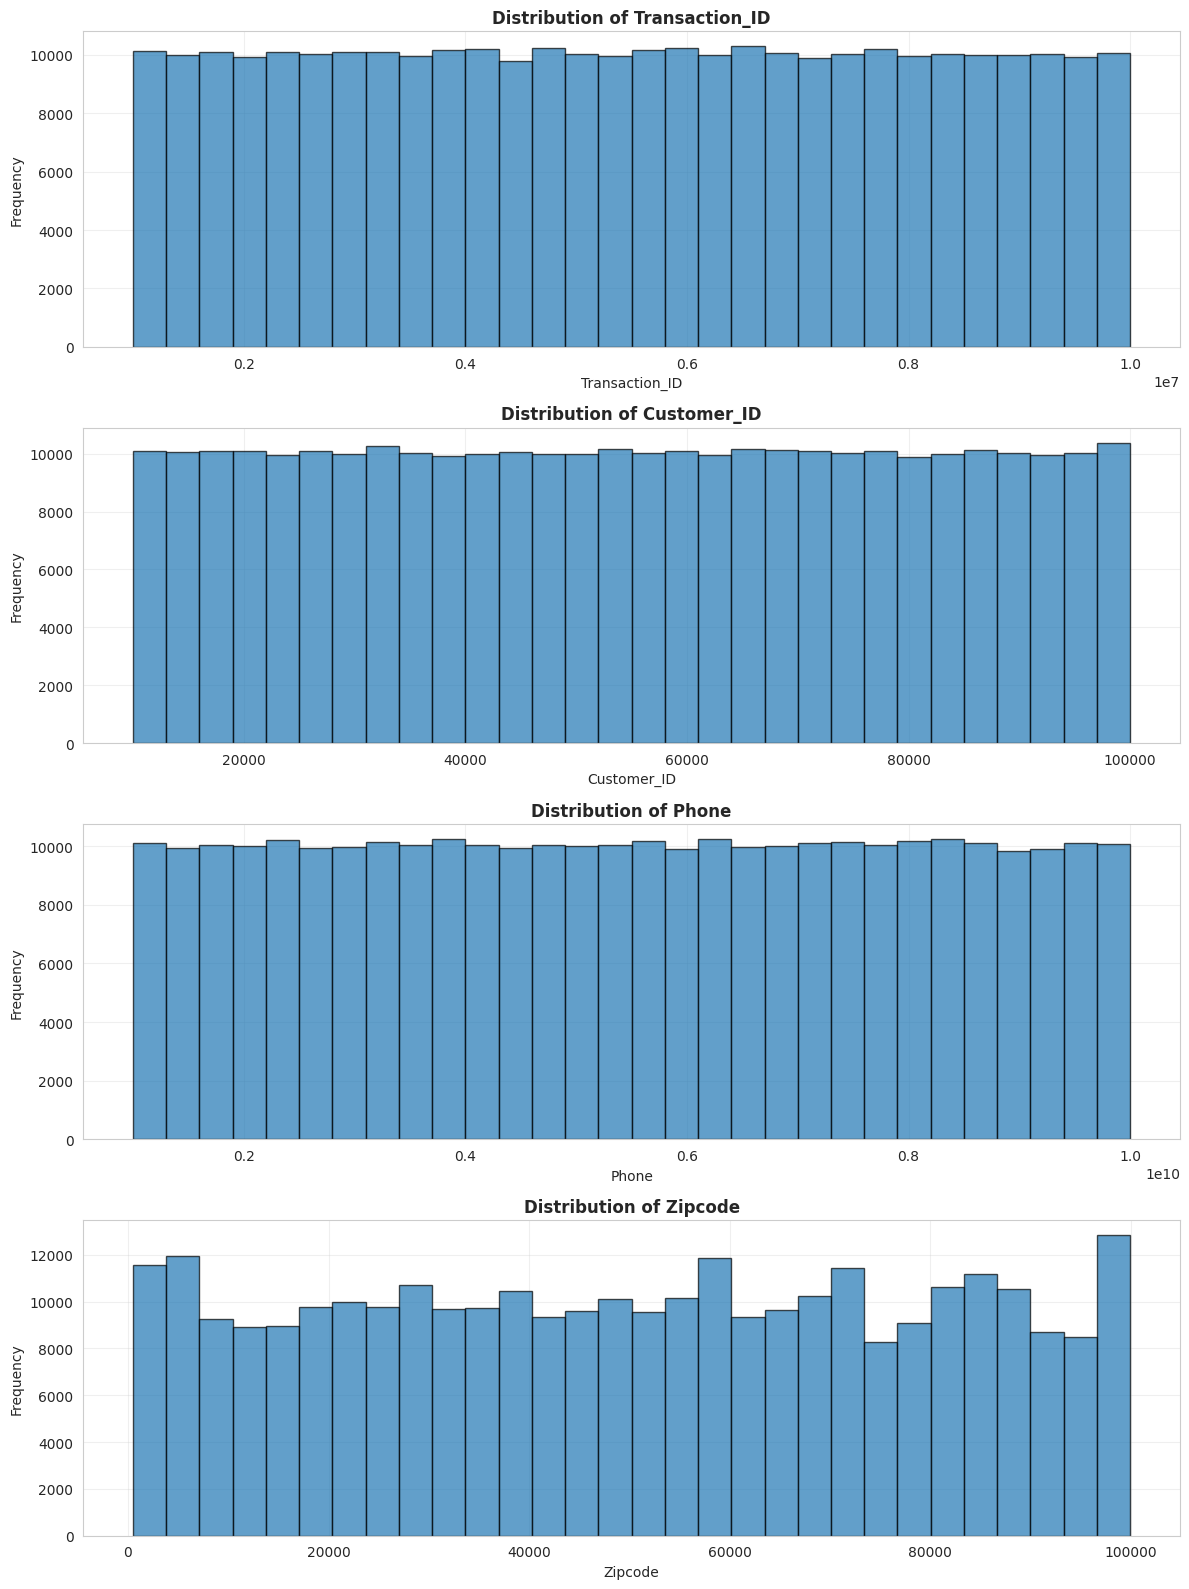

✅ Distribution plots generated


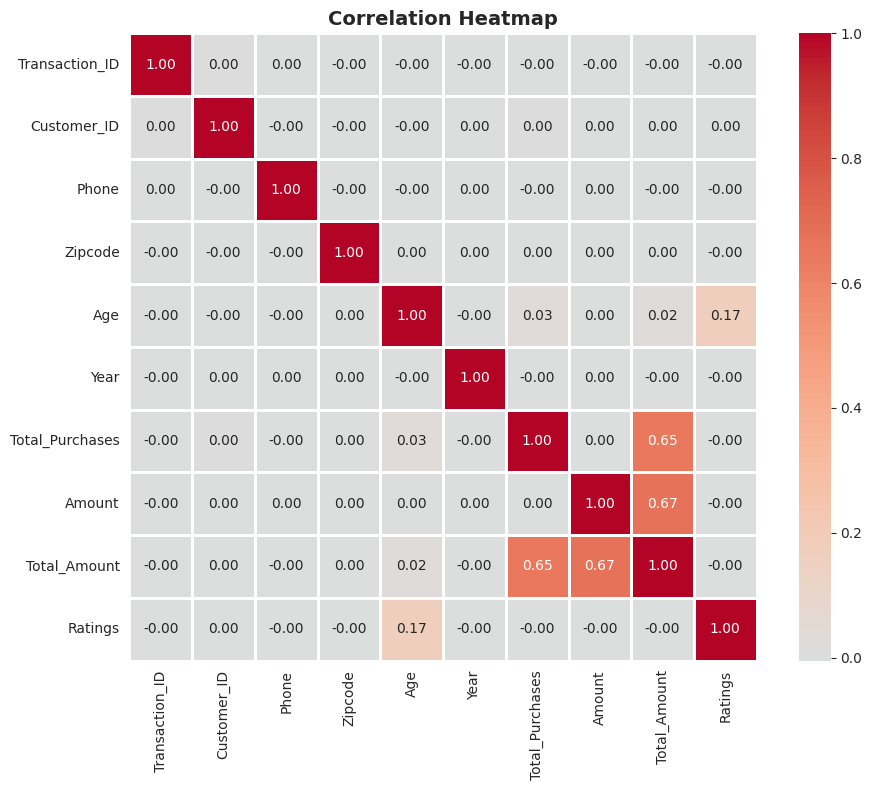

✅ Correlation heatmap generated


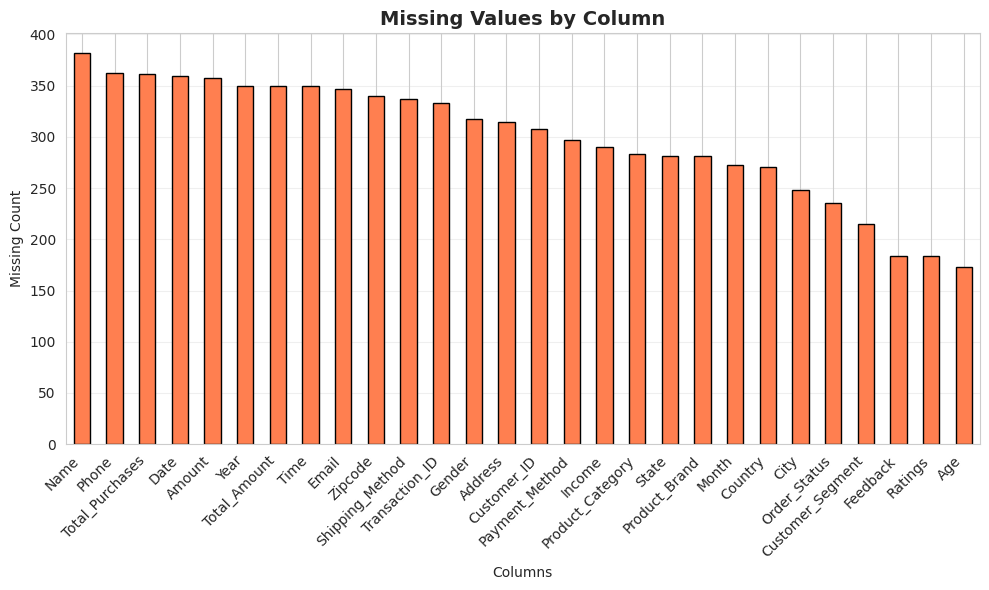

✅ Missing values chart generated

🧹 DATA CLEANING

📌 STEP 1: Removing Duplicates
--------------------------------------------------------------------------------
   Removed: 4 duplicate rows (0.00%)
   Remaining: 302,006 rows

📌 STEP 2: Handling Missing Values
--------------------------------------------------------------------------------
   Missing values found: 8,382
   ✓ Transaction_ID: Filled with MEDIAN
   ✓ Customer_ID: Filled with MEDIAN
   ✓ Name: Filled with MODE
   ✓ Email: Filled with MODE
   ✓ Phone: Filled with MEDIAN
   ✓ Address: Filled with MODE
   ✓ City: Filled with MODE
   ✓ State: Filled with MODE
   ✓ Zipcode: Filled with MEDIAN
   ✓ Country: Filled with MODE
   ✓ Age: Filled with MEDIAN
   ✓ Gender: Filled with MODE
   ✓ Income: Filled with MODE
   ✓ Customer_Segment: Filled with MODE
   ✓ Date: Filled with MODE
   ✓ Year: Filled with MEDIAN
   ✓ Month: Filled with MODE
   ✓ Time: Filled with MODE
   ✓ Total_Purchases: Filled with MEDIAN
   ✓ Amount: Filled with 

KeyError: 'amount'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


def perform_eda(file_path):
    """
    Perform comprehensive Exploratory Data Analysis on a dataset
    
    Parameters:
    -----------
    file_path : str
        Path to the CSV file
    
    Returns:
    --------
    df : DataFrame
        Loaded dataframe
    """
    
    print("="*80)
    print("EXPLORATORY DATA ANALYSIS (EDA)")
    print("="*80)
    
    # ========================================
    # 1. LOAD DATA
    # ========================================
    print("\n📁 STEP 1: LOADING DATA")
    print("-"*80)
    try:
        df = pd.read_csv(file_path)
        print(f"✅ Successfully loaded: {file_path}")
        print(f"   Rows: {df.shape[0]:,}")
        print(f"   Columns: {df.shape[1]}")
    except Exception as e:
        print(f"❌ Error loading file: {e}")
        return None
    
    # ========================================
    # 2. BASIC INFORMATION
    # ========================================
    print("\n" + "="*80)
    print("📊 STEP 2: BASIC INFORMATION")
    print("="*80)
    
    print("\n🔹 Column Names:")
    for i, col in enumerate(df.columns, 1):
        print(f"   {i}. {col}")
    
    print("\n🔹 Data Types:")
    print(df.dtypes)
    
    print("\n🔹 Dataset Shape:")
    print(f"   Rows: {df.shape[0]:,}")
    print(f"   Columns: {df.shape[1]}")
    print(f"   Total Cells: {df.shape[0] * df.shape[1]:,}")
    
    print("\n🔹 Memory Usage:")
    memory = df.memory_usage(deep=True).sum() / 1024**2
    print(f"   {memory:.2f} MB")
    
    # ========================================
    # 3. FIRST AND LAST ROWS
    # ========================================
    print("\n" + "="*80)
    print("👀 STEP 3: PREVIEW DATA")
    print("="*80)
    
    print("\n🔹 First 5 Rows:")
    print(df.head())
    
    print("\n🔹 Last 5 Rows:")
    print(df.tail())
    
    # ========================================
    # 4. MISSING VALUES
    # ========================================
    print("\n" + "="*80)
    print("🔍 STEP 4: MISSING VALUES ANALYSIS")
    print("="*80)
    
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'Column': missing.index,
        'Missing_Count': missing.values,
        'Percentage': missing_pct.values
    })
    missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
    
    if len(missing_df) > 0:
        print("\n⚠️ Columns with Missing Values:")
        print(missing_df.to_string(index=False))
        print(f"\nTotal missing values: {missing.sum():,}")
    else:
        print("\n✅ No missing values found!")
    
    # ========================================
    # 5. DUPLICATE ROWS
    # ========================================
    print("\n" + "="*80)
    print("🔄 STEP 5: DUPLICATE ROWS")
    print("="*80)
    
    duplicates = df.duplicated().sum()
    print(f"\nDuplicate rows: {duplicates:,} ({duplicates/len(df)*100:.2f}%)")
    
    if duplicates > 0:
        print("⚠️ Consider removing duplicates during data cleaning")
    else:
        print("✅ No duplicates found!")
    
    # ========================================
    # 6. STATISTICAL SUMMARY
    # ========================================
    print("\n" + "="*80)
    print("📈 STEP 6: STATISTICAL SUMMARY")
    print("="*80)
    
    print("\n🔹 Numeric Columns:")
    print(df.describe())
    
    print("\n🔹 Categorical Columns:")
    categorical_cols = df.select_dtypes(include=['object']).columns
    if len(categorical_cols) > 0:
        for col in categorical_cols:
            print(f"\n   {col}:")
            print(f"      Unique values: {df[col].nunique()}")
            print(f"      Most common: {df[col].mode()[0] if len(df[col].mode()) > 0 else 'N/A'}")
            if df[col].nunique() <= 10:
                print(f"      Value counts:")
                print(df[col].value_counts().head(10).to_string())
    else:
        print("   No categorical columns found")
    
    # ========================================
    # 7. DATA TYPES BREAKDOWN
    # ========================================
    print("\n" + "="*80)
    print("🏷️ STEP 7: DATA TYPES BREAKDOWN")
    print("="*80)
    
    print("\n🔹 Column Type Distribution:")
    dtype_counts = df.dtypes.value_counts()
    for dtype, count in dtype_counts.items():
        print(f"   {dtype}: {count} columns")
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    datetime_cols = df.select_dtypes(include=['datetime64']).columns.tolist()
    
    print(f"\n   Numeric columns ({len(numeric_cols)}): {numeric_cols}")
    print(f"   Categorical columns ({len(categorical_cols)}): {categorical_cols}")
    print(f"   Datetime columns ({len(datetime_cols)}): {datetime_cols}")
    
    # ========================================
    # 8. UNIQUE VALUES
    # ========================================
    print("\n" + "="*80)
    print("🔢 STEP 8: UNIQUE VALUES PER COLUMN")
    print("="*80)
    
    print("\n")
    unique_df = pd.DataFrame({
        'Column': df.columns,
        'Unique_Values': [df[col].nunique() for col in df.columns],
        'Unique_Percentage': [df[col].nunique()/len(df)*100 for col in df.columns]
    }).sort_values('Unique_Values', ascending=False)
    
    print(unique_df.to_string(index=False))
    
    # ========================================
    # 9. OUTLIERS DETECTION (IQR METHOD)
    # ========================================
    print("\n" + "="*80)
    print("📊 STEP 9: OUTLIER DETECTION")
    print("="*80)
    
    print("\n🔹 Outliers (IQR Method):")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    outlier_summary = []
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_count = len(outliers)
        outlier_pct = (outlier_count / len(df)) * 100
        
        if outlier_count > 0:
            outlier_summary.append({
                'Column': col,
                'Outliers': outlier_count,
                'Percentage': f"{outlier_pct:.2f}%",
                'Lower_Bound': f"{lower_bound:.2f}",
                'Upper_Bound': f"{upper_bound:.2f}"
            })
    
    if outlier_summary:
        outlier_df = pd.DataFrame(outlier_summary)
        print(outlier_df.to_string(index=False))
    else:
        print("   ✅ No outliers detected!")
    
    # ========================================
    # 10. CORRELATION ANALYSIS
    # ========================================
    print("\n" + "="*80)
    print("🔗 STEP 10: CORRELATION ANALYSIS")
    print("="*80)
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 1:
        print("\n🔹 Correlation Matrix:")
        corr_matrix = df[numeric_cols].corr()
        print(corr_matrix)
        
        # Find high correlations
        print("\n🔹 High Correlations (|r| > 0.7):")
        high_corr = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                if abs(corr_matrix.iloc[i, j]) > 0.7:
                    high_corr.append({
                        'Feature_1': corr_matrix.columns[i],
                        'Feature_2': corr_matrix.columns[j],
                        'Correlation': f"{corr_matrix.iloc[i, j]:.3f}"
                    })
        
        if high_corr:
            high_corr_df = pd.DataFrame(high_corr)
            print(high_corr_df.to_string(index=False))
        else:
            print("   No high correlations found")
    else:
        print("   ⚠️ Not enough numeric columns for correlation analysis")
    
    # ========================================
    # 11. VISUALIZATIONS
    # ========================================
    print("\n" + "="*80)
    print("📊 STEP 11: GENERATING VISUALIZATIONS")
    print("="*80)
    
    # Distribution plots for numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if len(numeric_cols) > 0:
        n_cols = min(len(numeric_cols), 4)
        fig, axes = plt.subplots(n_cols, 1, figsize=(12, 4*n_cols))
        if n_cols == 1:
            axes = [axes]
        
        for i, col in enumerate(numeric_cols[:4]):
            df[col].hist(bins=30, ax=axes[i], edgecolor='black', alpha=0.7)
            axes[i].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Frequency')
            axes[i].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        print("✅ Distribution plots generated")
    
    # Correlation heatmap
    if len(numeric_cols) > 1:
        plt.figure(figsize=(10, 8))
        sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', 
                    center=0, fmt='.2f', square=True, linewidths=1)
        plt.title('Correlation Heatmap', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        print("✅ Correlation heatmap generated")
    
    # Missing values visualization
    if df.isnull().sum().sum() > 0:
        plt.figure(figsize=(10, 6))
        missing_data = df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False)
        missing_data.plot(kind='bar', color='coral', edgecolor='black')
        plt.title('Missing Values by Column', fontsize=14, fontweight='bold')
        plt.xlabel('Columns')
        plt.ylabel('Missing Count')
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()
        print("✅ Missing values chart generated")
    
    return df


def clean_data(df, remove_duplicates=True, handle_missing='auto', handle_outliers='cap'):
    """
    Clean the dataset by handling missing values, duplicates, and outliers
    
    Parameters:
    -----------
    df : DataFrame
        Input dataframe
    remove_duplicates : bool
        Whether to remove duplicate rows (default: True)
    handle_missing : str
        Method to handle missing values: 'auto', 'drop', 'mean', 'median', 'mode', 'forward_fill'
    handle_outliers : str
        Method to handle outliers: 'cap', 'remove', 'none'
    
    Returns:
    --------
    df_clean : DataFrame
        Cleaned dataframe
    """
    
    print("\n" + "="*80)
    print("🧹 DATA CLEANING")
    print("="*80)
    
    df_clean = df.copy()
    initial_rows = len(df_clean)
    
    # ========================================
    # 1. REMOVE DUPLICATES
    # ========================================
    if remove_duplicates:
        print("\n📌 STEP 1: Removing Duplicates")
        print("-"*80)
        before = len(df_clean)
        df_clean.drop_duplicates(inplace=True)
        after = len(df_clean)
        removed = before - after
        print(f"   Removed: {removed:,} duplicate rows ({removed/before*100:.2f}%)")
        print(f"   Remaining: {after:,} rows")
    
    # ========================================
    # 2. HANDLE MISSING VALUES
    # ========================================
    print("\n📌 STEP 2: Handling Missing Values")
    print("-"*80)
    
    missing_before = df_clean.isnull().sum().sum()
    
    if missing_before > 0:
        print(f"   Missing values found: {missing_before:,}")
        
        for col in df_clean.columns:
            if df_clean[col].isnull().sum() > 0:
                missing_count = df_clean[col].isnull().sum()
                missing_pct = (missing_count / len(df_clean)) * 100
                
                # Auto strategy: drop if >50% missing, else fill
                if handle_missing == 'auto':
                    if missing_pct > 50:
                        print(f"   ⚠️ {col}: {missing_pct:.1f}% missing - DROPPING COLUMN")
                        df_clean.drop(columns=[col], inplace=True)
                        continue
                    else:
                        if df_clean[col].dtype in ['float64', 'int64']:
                            df_clean[col].fillna(df_clean[col].median(), inplace=True)
                            print(f"   ✓ {col}: Filled with MEDIAN")
                        else:
                            df_clean[col].fillna(df_clean[col].mode()[0] if len(df_clean[col].mode()) > 0 else 'Unknown', inplace=True)
                            print(f"   ✓ {col}: Filled with MODE")
                
                elif handle_missing == 'drop':
                    df_clean.dropna(subset=[col], inplace=True)
                    print(f"   ✓ {col}: Dropped rows with missing values")
                
                elif handle_missing == 'mean':
                    if df_clean[col].dtype in ['float64', 'int64']:
                        df_clean[col].fillna(df_clean[col].mean(), inplace=True)
                        print(f"   ✓ {col}: Filled with MEAN")
                
                elif handle_missing == 'median':
                    if df_clean[col].dtype in ['float64', 'int64']:
                        df_clean[col].fillna(df_clean[col].median(), inplace=True)
                        print(f"   ✓ {col}: Filled with MEDIAN")
                
                elif handle_missing == 'mode':
                    df_clean[col].fillna(df_clean[col].mode()[0] if len(df_clean[col].mode()) > 0 else 'Unknown', inplace=True)
                    print(f"   ✓ {col}: Filled with MODE")
                
                elif handle_missing == 'forward_fill':
                    df_clean[col].fillna(method='ffill', inplace=True)
                    print(f"   ✓ {col}: Forward filled")
        
        missing_after = df_clean.isnull().sum().sum()
        print(f"\n   Missing values remaining: {missing_after:,}")
    else:
        print("   ✅ No missing values to handle")
    
    # ========================================
    # 3. HANDLE OUTLIERS
    # ========================================
    print("\n📌 STEP 3: Handling Outliers")
    print("-"*80)
    
    if handle_outliers != 'none':
        numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
        
        for col in numeric_cols:
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outlier_mask = (df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)
            outlier_count = outlier_mask.sum()
            
            if outlier_count > 0:
                if handle_outliers == 'cap':
                    # Cap outliers at bounds
                    df_clean.loc[df_clean[col] < lower_bound, col] = lower_bound
                    df_clean.loc[df_clean[col] > upper_bound, col] = upper_bound
                    print(f"   ✓ {col}: Capped {outlier_count} outliers ({outlier_count/len(df_clean)*100:.2f}%)")
                
                elif handle_outliers == 'remove':
                    # Remove rows with outliers
                    df_clean = df_clean[~outlier_mask]
                    print(f"   ✓ {col}: Removed {outlier_count} outliers ({outlier_count/len(df)*100:.2f}%)")
        
        print(f"\n   Rows after outlier handling: {len(df_clean):,}")
    else:
        print("   ⏭️ Skipping outlier handling")
    
    # ========================================
    # 4. CONVERT DATA TYPES
    # ========================================
    print("\n📌 STEP 4: Converting Data Types")
    print("-"*80)
    
    # Auto-detect and convert date columns
    date_keywords = ['date', 'time', 'timestamp', 'datetime']
    for col in df_clean.columns:
        if any(keyword in col.lower() for keyword in date_keywords):
            try:
                df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')
                print(f"   ✓ {col}: Converted to datetime")
            except:
                print(f"   ⚠️ {col}: Could not convert to datetime")
    
    # ========================================
    # 5. SUMMARY
    # ========================================
    print("\n" + "="*80)
    print("📋 CLEANING SUMMARY")
    print("="*80)
    
    final_rows = len(df_clean)
    rows_removed = initial_rows - final_rows
    
    print(f"""
✅ DATA CLEANING COMPLETED!

📊 Summary:
   • Initial rows: {initial_rows:,}
   • Final rows: {final_rows:,}
   • Rows removed: {rows_removed:,} ({rows_removed/initial_rows*100:.2f}%)
   • Columns: {df_clean.shape[1]}
   • Missing values: {df_clean.isnull().sum().sum():,}
   • Duplicates: {df_clean.duplicated().sum():,}
    """)
    
    return df_clean


def feature_engineering(df, customer_id_col, date_col, transaction_amt_col, 
                       points_rate=0.1, calculate_rfm=True):
    """
    Perform feature engineering including loyalty points and RFM analysis
    
    Parameters:
    -----------
    df : DataFrame
        Input cleaned dataframe
    customer_id_col : str
        Column name for customer ID
    date_col : str
        Column name for transaction date
    transaction_amt_col : str
        Column name for transaction amount
    points_rate : float
        Points earned per dollar
    calculate_rfm : bool
        Whether to calculate RFM metrics
    
    Returns:
    --------
    df_featured : DataFrame
        Dataframe with new features
    rfm_df : DataFrame (optional)
        RFM analysis summary
    """
    
    print("\n" + "="*80)
    print("🔧 FEATURE ENGINEERING")
    print("="*80)
    
    df_featured = df.copy()
    
    # ========================================
    # 1. CALCULATE LOYALTY POINTS
    # ========================================
    print("\n📌 STEP 1: Calculating Loyalty Points")
    print("-"*80)
    
    # Accrued points for current transaction
    df_featured['accrued_points'] = df_featured[transaction_amt_col] * points_rate
    df_featured['accrued_points'] = df_featured['accrued_points'].round(2)
    
    print(f"   Points rate: {points_rate} points per dollar")
    print(f"   Total points accrued: {df_featured['accrued_points'].sum():,.2f}")
    print(f"   Average points per transaction: {df_featured['accrued_points'].mean():.2f}")
    
    # ========================================
    # 2. UPDATE CUSTOMER BALANCES
    # ========================================
    print("\n📌 STEP 2: Updating Customer Point Balances")
    print("-"*80)
    
    # Calculate cumulative points per customer
    customer_points = df_featured.groupby(customer_id_col)['accrued_points'].sum().reset_index()
    customer_points.rename(columns={'accrued_points': 'total_point_balance'}, inplace=True)
    
    # Merge back
    df_featured = df_featured.merge(customer_points, on=customer_id_col, how='left')
    
    print(f"   Total customers: {df_featured[customer_id_col].nunique():,}")
    print(f"   Average balance per customer: {customer_points['total_point_balance'].mean():.2f}")
    print(f"   Top customer balance: {customer_points['total_point_balance'].max():,.2f}")
    
    # ========================================
    # 3. CALCULATE RFM METRICS
    # ========================================
    rfm_df = None
    if calculate_rfm:
        print("\n📌 STEP 3: Calculating RFM Metrics")
        print("-"*80)
        
        # Ensure date column is datetime
        if df_featured[date_col].dtype != 'datetime64[ns]':
            df_featured[date_col] = pd.to_datetime(df_featured[date_col])
        
        reference_date = df_featured[date_col].max()
        
        # Calculate RFM
        rfm_df = df_featured.groupby(customer_id_col).agg({
            date_col: lambda x: (reference_date - x.max()).days,  # Recency
            customer_id_col: 'count',  # Frequency
            transaction_amt_col: 'sum'  # Monetary
        }).reset_index()
        
        rfm_df.columns = [customer_id_col, 'recency', 'frequency', 'monetary']
        
        # Calculate RFM scores (1-5)
        rfm_df['R_score'] = pd.qcut(rfm_df['recency'], 5, labels=[5,4,3,2,1], duplicates='drop').astype(int)
        rfm_df['F_score'] = pd.qcut(rfm_df['frequency'].rank(method='first'), 5, labels=[1,2,3,4,5], duplicates='drop').astype(int)
        rfm_df['M_score'] = pd.qcut(rfm_df['monetary'], 5, labels=[1,2,3,4,5], duplicates='drop').astype(int)
        
        # Composite RFM score
        rfm_df['RFM_score'] = rfm_df['R_score'] + rfm_df['F_score'] + rfm_df['M_score']
        
        # Customer segmentation
        def segment_customer(score):
            if score >= 13:
                return 'Champions'
            elif score >= 10:
                return 'Loyal Customers'
            elif score >= 7:
                return 'Potential Loyalists'
            elif score >= 5:
                return 'At Risk'
            else:
                return 'Lost'
        
        rfm_df['customer_segment'] = rfm_df['RFM_score'].apply(segment_customer)
        
        # Merge RFM back to main dataframe
        df_featured = df_featured.merge(
            rfm_df[[customer_id_col, 'recency', 'frequency', 'monetary', 
                    'R_score', 'F_score', 'M_score', 'RFM_score', 'customer_segment']], 
            on=customer_id_col, 
            how='left'
        )
        
        print(f"   Reference date: {reference_date.strftime('%Y-%m-%d')}")
        print(f"\n   Recency (days):")
        print(f"      Mean: {rfm_df['recency'].mean():.1f}")
        print(f"      Median: {rfm_df['recency'].median():.1f}")
        print(f"\n   Frequency (transactions):")
        print(f"      Mean: {rfm_df['frequency'].mean():.1f}")
        print(f"      Median: {rfm_df['frequency'].median():.1f}")
        print(f"\n   Monetary (total spend):")
        print(f"      Mean: ${rfm_df['monetary'].mean():,.2f}")
        print(f"      Median: ${rfm_df['monetary'].median():,.2f}")
        
        print("\n   Customer Segments:")
        for segment, count in rfm_df['customer_segment'].value_counts().sort_index().items():
            print(f"      {segment}: {count} ({count/len(rfm_df)*100:.1f}%)")
    
    # ========================================
    # 4. ADDITIONAL FEATURES
    # ========================================
    print("\n📌 STEP 4: Creating Additional Features")
    print("-"*80)
    
    # Time-based features
    if df_featured[date_col].dtype == 'datetime64[ns]':
        df_featured['year'] = df_featured[date_col].dt.year
        df_featured['month'] = df_featured[date_col].dt.month
        df_featured['day'] = df_featured[date_col].dt.day
        df_featured['day_of_week'] = df_featured[date_col].dt.dayofweek
        df_featured['quarter'] = df_featured[date_col].dt.quarter
        print("   ✓ Created time-based features: year, month, day, day_of_week, quarter")
    
    # Transaction features
    df_featured['transaction_rank'] = df_featured.groupby(customer_id_col).cumcount() + 1
    print("   ✓ Created transaction_rank (sequential transaction number per customer)")
    
    print("\n" + "="*80)
    print("✅ FEATURE ENGINEERING COMPLETED!")
    print("="*80)
    print(f"\nNew features added: {df_featured.shape[1] - df.shape[1]}")
    print(f"Final dataset shape: {df_featured.shape}")
    
    return df_featured, rfm_df


# ============================================
# COMPLETE PIPELINE
# ============================================

def complete_pipeline(file_path, 
                     customer_id_col='customer_id',
                     date_col='transaction_date',
                     transaction_amt_col='amount',
                     points_rate=0.1,
                     remove_duplicates=True,
                     handle_missing='auto',
                     handle_outliers='cap',
                     output_folder='output'):
    """
    Complete EDA, cleaning, and feature engineering pipeline
    
    Parameters:
    -----------
    file_path : str
        Path to CSV file
    customer_id_col : str
        Customer ID column name
    date_col : str
        Transaction date column name
    transaction_amt_col : str
        Transaction amount column name
    points_rate : float
        Points per dollar (default: 0.1)
    remove_duplicates : bool
        Remove duplicate rows (default: True)
    handle_missing : str
        Missing value strategy: 'auto', 'drop', 'mean', 'median', 'mode', 'forward_fill'
    handle_outliers : str
        Outlier strategy: 'cap', 'remove', 'none'
    output_folder : str
        Folder for output files
    
    Returns:
    --------
    df_final : DataFrame
        Final processed dataframe
    rfm_df : DataFrame
        RFM analysis results
    """
    
    import os
    
    # Create output folder
    os.makedirs(output_folder, exist_ok=True)
    
    print("\n" + "🚀 "*40)
    print("COMPLETE DATA PROCESSING PIPELINE")
    print("🚀 "*40)
    
    # Step 1: EDA
    df = perform_eda(file_path)
    if df is None:
        return None, None
    
    # Step 2: Data Cleaning
    df_clean = clean_data(df, remove_duplicates, handle_missing, handle_outliers)
    
    # Step 3: Feature Engineering
    df_final, rfm_df = feature_engineering(
        df_clean, 
        customer_id_col, 
        date_col, 
        transaction_amt_col,
        points_rate
    )
    
    # Step 4: Export Results
    print("\n" + "="*80)
    print("💾 EXPORTING RESULTS")
    print("="*80)
    
    output_files = {
        'cleaned_data': os.path.join(output_folder, 'cleaned_loyalty_data.csv'),
        'rfm_analysis': os.path.join(output_folder, 'rfm_analysis.csv'),
    }
    
    try:
        df_final.to_csv(output_files['cleaned_data'], index=False)
        print(f"✅ Cleaned data saved: {output_files['cleaned_data']}")
        
        if rfm_df is not None:
            rfm_df.to_csv(output_files['rfm_analysis'], index=False)
            print(f"✅ RFM analysis saved: {output_files['rfm_analysis']}")
    except Exception as e:
        print(f"⚠️ Error saving files: {e}")
    
    print("\n" + "✨ "*40)
    print("PIPELINE COMPLETED SUCCESSFULLY!")
    print("✨ "*40)
    
    return df_final, rfm_df


# ============================================
# USAGE EXAMPLES
# ============================================

if __name__ == "__main__":
    
    # ===========================================
    # OPTION 1: Run complete pipeline (RECOMMENDED)
    # ===========================================
    
    # Just provide your file path and column names
    df_final, rfm_df = complete_pipeline(
        file_path='/kaggle/input/retail/retail_data.csv',              # 👈 CHANGE THIS to your file path
        customer_id_col='customer_id',           # 👈 Your customer ID column
        date_col='transaction_date',             # 👈 Your date column
        transaction_amt_col='amount',            # 👈 Your amount column
        points_rate=0.1,                         # 10 points per $100
        remove_duplicates=True,
        handle_missing='auto',
        handle_outliers='cap',
        output_folder='output'
    )
    
    
    # ===========================================
    # OPTION 2: Run step by step
    # ===========================================
    
    # # Step 1: EDA only
    # df = perform_eda('your_data.csv')  # 👈 CHANGE THIS
    
    # # Step 2: Clean data
    # df_clean = clean_data(
    #     df, 
    #     remove_duplicates=True,
    #     handle_missing='auto',  # Options: 'auto', 'drop', 'mean', 'median', 'mode'
    #     handle_outliers='cap'   # Options: 'cap', 'remove', 'none'
    # )
    
    # # Step 3: Feature engineering
    # df_final, rfm_df = feature_engineering(
    #     df_clean,
    #     customer_id_col='customer_id',      # 👈 CHANGE THIS
    #     date_col='transaction_date',         # 👈 CHANGE THIS
    #     transaction_amt_col='amount',        # 👈 CHANGE THIS
    #     points_rate=0.1,
    #     calculate_rfm=True
    # )
    
    # # Step 4: Save results
    # df_final.to_csv('cleaned_data.csv', index=False)
    # rfm_df.to_csv('rfm_analysis.csv', index=False)

****Final pipeline**************

**************Pipeline dividing into 5 tables**********************************

In [2]:
"""
FINAL FIXED retail_etl_pipeline.py
All FK/PK/UNIQUE errors resolved.
"""

import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from datetime import datetime


def parse_mixed_date(series: pd.Series) -> pd.Series:
    s = series.astype(str)
    res = pd.Series(pd.NaT, index=s.index, dtype='datetime64[ns]')
    mask_slash = s.str.contains("/")
    mask_dash = s.str.contains("-")

    res.loc[mask_slash] = pd.to_datetime(s.loc[mask_slash],
        format="%m/%d/%Y", errors="coerce")

    res.loc[mask_dash] = pd.to_datetime(s.loc[mask_dash],
        format="%m-%d-%y", errors="coerce")

    return res


def safe_int_str(series: pd.Series) -> pd.Series:
    return series.astype("Int64").astype(str)


# -------------------------------------------------------------------
# 2. Load raw data
# -------------------------------------------------------------------

CSV_PATH = "/kaggle/input/good-dataset/good_data.csv"
DB_URL = "sqlite:///retail.db"

print("🔹 Loading CSV...")
raw = pd.read_csv(CSV_PATH)

raw["tx_date"] = parse_mixed_date(raw["Date"])
raw["customer_id"] = safe_int_str(raw["Customer_ID"])
raw["transaction_id"] = safe_int_str(raw["Transaction_ID"])


def build_customer_master(df):
    g = df.dropna(subset=["customer_id"]).groupby("customer_id")

    cm = g.agg({
        "Name":"first","Email":"first","Phone":"first",
        "Address":"first","City":"first","State":"first",
        "Zipcode":"first","Country":"first","Age":"first",
        "Gender":"first","Income":"first","Customer_Segment":"first",
        "tx_date":["min","max"]
    }).reset_index()

    cm.columns = [
        "customer_id","name","email","phone","address","city","state","zipcode",
        "country","age","gender","income","customer_segment",
        "customer_since","last_purchase_date"
    ]

    cm["is_loyalty_member"] = True
    cm["total_loyalty_points"] = 0
    cm["bonus_points"] = 0
    cm["last_points_update"] = pd.NaT

    cm["zipcode"] = cm["zipcode"].astype("Int64").astype(str)
    cm["age"] = cm["age"].astype("Int64")
    cm["income"] = pd.to_numeric(cm["income"], errors="coerce")

    # CLEAN duplicated keys
    cm = cm.drop_duplicates(subset=["customer_id"])

    return cm


def build_product_master(df):
    pm = df[["Product_Category","Product_Brand","Product_Type","products"]].drop_duplicates()
    pm = pm.rename(columns={
        "Product_Category":"product_category",
        "Product_Brand":"product_brand",
        "Product_Type":"product_type",
        "products":"product_full_name"
    })

    pm = pm.reset_index(drop=True)
    pm["product_key"] = pm.index.to_series().add(1).map(lambda x: f"P{x:06d}")
    pm["is_active"] = True

    return pm[[
        "product_key","product_category","product_brand","product_type",
        "product_full_name","is_active"
    ]]


def build_sales_transactions(df):
    st = df.copy()
    st["date"] = st["tx_date"]
    st["year"] = st["date"].dt.year
    st["month"] = st["date"].dt.month

    month_map = {
        "January":1,"February":2,"March":3,"April":4,"May":5,"June":6,
        "July":7,"August":8,"September":9,"October":10,"November":11,"December":12
    }
    nat_mask = st["date"].isna()
    st.loc[nat_mask,"year"] = st.loc[nat_mask,"Year"].astype("Int64")
    st.loc[nat_mask,"month"] = st.loc[nat_mask,"Month"].map(month_map)

    st["ingestion_timestamp"] = datetime.utcnow()
    st["data_quality_flag"] = "PASS"
    st["reject_reason"] = pd.NA

    st_df = st.rename(columns={
        "Time":"time",
        "Total_Purchases":"total_purchases",
        "Amount":"amount",
        "Total_Amount":"total_amount",
        "Product_Category":"product_category",
        "Product_Brand":"product_brand",
        "Product_Type":"product_type",
        "Shipping_Method":"shipping_method",
        "Payment_Method":"payment_method",
        "Order_Status":"order_status",
        "Ratings":"ratings",
        "Feedback":"feedback"
    })

    st_df = st_df[[
        "transaction_id","customer_id","date","year","month","time",
        "total_purchases","amount","total_amount","product_category",
        "product_brand","product_type","shipping_method","payment_method",
        "order_status","ratings","feedback","ingestion_timestamp",
        "data_quality_flag","reject_reason"
    ]]

    # CLEAN null + duplicate transaction IDs
    st_df = st_df.dropna(subset=["transaction_id"])
    st_df = st_df[st_df["transaction_id"] != "<NA>"]
    st_df = st_df.drop_duplicates(subset=["transaction_id"])

    return st_df


def build_customer_analytics(st_df):
    snapshot_date = st_df["date"].max()
    g = st_df.groupby("customer_id")

    base = g.agg({
        "date":"max","transaction_id":"nunique","total_amount":"sum",
        "product_type":"nunique","ratings":"mean"
    }).reset_index()

    base = base.rename(columns={
        "date":"last_purchase_date","transaction_id":"frequency",
        "total_amount":"monetary","product_type":"product_diversity",
        "ratings":"avg_rating"
    })

    base["recency"] = (snapshot_date - base["last_purchase_date"]).dt.days
    base["avg_rating"] = base["avg_rating"].fillna(0)
    base["monetary"] = base["monetary"].fillna(0)
    base["recency"] = base["recency"].fillna(base["recency"].max())

    base["rfm_score"] = 1
    base["segment"] = "Medium"
    base["clv_score"] = (
        base["monetary"] * base["frequency"] / (base["recency"] + 1)
    )

    base["snapshot_date"] = snapshot_date

    return base[[
        "customer_id","recency","frequency","monetary",
        "rfm_score","segment","product_diversity","avg_rating",
        "clv_score","snapshot_date"
    ]]


def build_loyalty_transactions(st_df):
    lt = st_df[[
        "transaction_id","customer_id","date","total_amount"
    ]].copy()

    lt["points_earned"] = lt["total_amount"].fillna(0).floordiv(10).astype(int)
    lt["points_redeemed"] = 0
    lt["bonus_points"] = 0

    lt = lt.sort_values(["customer_id","date","transaction_id"])
    lt["balance_after"] = lt.groupby("customer_id")["points_earned"].cumsum()

    lt["event_date"] = lt["date"]
    lt["event_type"] = "EARN"

    lt = lt.reset_index(drop=True)
    lt["loyalty_txn_id"] = lt.index.to_series().add(1).map(lambda x: f"L{x:07d}")

    return lt[[
        "loyalty_txn_id","customer_id","transaction_id","points_earned",
        "points_redeemed","bonus_points","balance_after","event_date",
        "event_type"
    ]]


# -------------------------------------------------------------------
# 4. Build all DataFrames
# -------------------------------------------------------------------

print("🔹 Building normalized tables...")

customer_master_df = build_customer_master(raw)
product_master_df = build_product_master(raw)
sales_transactions_df = build_sales_transactions(raw)
customer_analytics_df = build_customer_analytics(sales_transactions_df)
loyalty_transactions_df = build_loyalty_transactions(sales_transactions_df)

# -------------------------------------------------------------------
# 5. CREATE TABLES
# -------------------------------------------------------------------

engine = create_engine(DB_URL)

DDL = [
    "DROP TABLE IF EXISTS loyalty_transactions;",
    "DROP TABLE IF EXISTS customer_analytics;",
    "DROP TABLE IF EXISTS sales_transactions;",
    "DROP TABLE IF EXISTS product_master;",
    "DROP TABLE IF EXISTS customer_master;",

    """
    CREATE TABLE customer_master (
        customer_id VARCHAR PRIMARY KEY,
        name VARCHAR,
        email VARCHAR,
        phone VARCHAR,
        address VARCHAR,
        city VARCHAR,
        state VARCHAR,
        zipcode VARCHAR,
        country VARCHAR,
        age INT,
        gender VARCHAR,
        income DECIMAL,
        customer_segment VARCHAR,
        is_loyalty_member BOOLEAN,
        customer_since DATE,
        total_loyalty_points INT,
        bonus_points INT,
        last_points_update DATE,
        last_purchase_date DATE
    );
    """,

    """
    CREATE TABLE product_master (
        product_key VARCHAR PRIMARY KEY,
        product_category VARCHAR,
        product_brand VARCHAR,
        product_type VARCHAR,
        product_full_name VARCHAR,
        is_active BOOLEAN
    );
    """,

    """
    CREATE TABLE sales_transactions (
        transaction_id VARCHAR PRIMARY KEY,
        customer_id VARCHAR,
        date DATE,
        year INT,
        month INT,
        time VARCHAR,
        total_purchases INT,
        amount DECIMAL,
        total_amount DECIMAL,
        product_category VARCHAR,
        product_brand VARCHAR,
        product_type VARCHAR,
        shipping_method VARCHAR,
        payment_method VARCHAR,
        order_status VARCHAR,
        ratings INT,
        feedback TEXT,
        ingestion_timestamp TIMESTAMP,
        data_quality_flag VARCHAR,
        reject_reason TEXT,
        FOREIGN KEY(customer_id) REFERENCES	customer_master(customer_id)
    );
    """,

    """
    CREATE TABLE customer_analytics (
        customer_id VARCHAR PRIMARY KEY,
        recency INT,
        frequency INT,
        monetary DECIMAL,
        rfm_score INT,
        segment VARCHAR,
        product_diversity INT,
        avg_rating DECIMAL,
        clv_score DECIMAL,
        snapshot_date DATE,
        FOREIGN KEY(customer_id) REFERENCES customer_master(customer_id)
    );
    """,

    """
    CREATE TABLE loyalty_transactions (
        loyalty_txn_id VARCHAR PRIMARY KEY,
        customer_id VARCHAR,
        transaction_id VARCHAR,
        points_earned INT,
        points_redeemed INT,
        bonus_points INT,
        balance_after INT,
        event_date DATE,
        event_type VARCHAR,
        FOREIGN KEY(customer_id) REFERENCES customer_master(customer_id),
        FOREIGN KEY(transaction_id) REFERENCES sales_transactions(transaction_id)
    );
    """
]

print("🔹 Creating database schema...")
with engine.begin() as conn:
    conn.exec_driver_sql("PRAGMA foreign_keys = OFF;")  
    for stmt in DDL:
        conn.exec_driver_sql(stmt)
    conn.exec_driver_sql("PRAGMA foreign_keys = ON;")    

# -------------------------------------------------------------------
# 6. LOAD DATA
# -------------------------------------------------------------------

print("🔹 Loading data into DB...")

customer_master_df.to_sql("customer_master", engine, if_exists="append", index=False)
product_master_df.to_sql("product_master", engine, if_exists="append", index=False)
sales_transactions_df.to_sql("sales_transactions", engine, if_exists="append", index=False)
customer_analytics_df.to_sql("customer_analytics", engine, if_exists="append", index=False)
loyalty_transactions_df.to_sql("loyalty_transactions", engine, if_exists="append", index=False)

print("✅ ETL pipeline finished. retail.db created!")


🔹 Loading CSV...
🔹 Building normalized tables...
🔹 Creating database schema...
🔹 Loading data into DB...
✅ ETL pipeline finished. retail.db created!


**sqlite database connections**

In [3]:
import sqlite3
conn = sqlite3.connect("retail.db")
cursor = conn.cursor()


In [4]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
cursor.fetchall()


[('customer_master',),
 ('product_master',),
 ('sales_transactions',),
 ('customer_analytics',),
 ('loyalty_transactions',)]

Customer_master table

In [5]:
cursor.execute("PRAGMA table_info(customer_master);")
rows = cursor.fetchall()

for r in rows:
    print(r)


(0, 'customer_id', 'VARCHAR', 0, None, 1)
(1, 'name', 'VARCHAR', 0, None, 0)
(2, 'email', 'VARCHAR', 0, None, 0)
(3, 'phone', 'VARCHAR', 0, None, 0)
(4, 'address', 'VARCHAR', 0, None, 0)
(5, 'city', 'VARCHAR', 0, None, 0)
(6, 'state', 'VARCHAR', 0, None, 0)
(7, 'zipcode', 'VARCHAR', 0, None, 0)
(8, 'country', 'VARCHAR', 0, None, 0)
(9, 'age', 'INT', 0, None, 0)
(10, 'gender', 'VARCHAR', 0, None, 0)
(11, 'income', 'DECIMAL', 0, None, 0)
(12, 'customer_segment', 'VARCHAR', 0, None, 0)
(13, 'is_loyalty_member', 'BOOLEAN', 0, None, 0)
(14, 'customer_since', 'DATE', 0, None, 0)
(15, 'total_loyalty_points', 'INT', 0, None, 0)
(16, 'bonus_points', 'INT', 0, None, 0)
(17, 'last_points_update', 'DATE', 0, None, 0)
(18, 'last_purchase_date', 'DATE', 0, None, 0)


In [6]:
import pandas as pd

df = pd.read_sql_query("SELECT * FROM sales_transactions LIMIT 10;", conn)
df


,transaction_id,customer_id,date,year,month,time,total_purchases,amount,total_amount,product_category,product_brand,product_type,shipping_method,payment_method,order_status,ratings,feedback,ingestion_timestamp,data_quality_flag,reject_reason
0,8691788,37249,None,2023,9,22:03:55,3,108.028757,324.086270,Clothing,Nike,Shorts,Same-Day,Debit Card,Shipped,5,Excellent,2025-11-15 12:26:18.741971,PASS,None
1,2174773,69749,None,2023,12,08:42:04,2,403.353907,806.707815,Electronics,Samsung,Tablet,Standard,Credit Card,Processing,4,Excellent,2025-11-15 12:26:18.741971,PASS,None
2,6679610,30192,None,2023,4,04:06:29,3,354.477600,1063.432799,Books,Penguin Books,Children's,Same-Day,Credit Card,Processing,2,Average,2025-11-15 12:26:18.741971,PASS,None
3,7232460,62101,None,2023,5,14:55:17,7,352.407717,2466.854021,Home Decor,Home Depot,Tools,Standard,PayPal,Processing,4,Excellent,2025-11-15 12:26:18.741971,PASS,None
4,4983775,27901,None,2024,1,16:54:07,2,124.276524,248.553049,Grocery,Nestle,Chocolate,Standard,Cash,Shipped,1,Bad,2025-11-15 12:26:18.741971,PASS,None
5,6095326,41289,None,2023,9,23:24:27,4,296.291806,1185.167224,Electronics,Apple,Tablet,Express,PayPal,Pending,4,Good,2025-11-15 12:26:18.741971,PASS,None
6,5434096,97285,None,2023,6,13:35:51,2,315.057648,630.115295,Electronics,Samsung,Television,Standard,Cash,Processing,1,Bad,2025-11-15 12:26:18.741971,PASS,None
7,2344675,26603,None,2023,3,10:12:56,1,46.588070,46.588070,Clothing,Zara,Shirt,Same-Day,Cash,Processing,1,Bad,2025-11-15 12:26:18.741971,PASS,None
8,4155845,80175,None,2024,1,14:38:26,8,328.839302,2630.714413,Grocery,Nestle,Chocolate,Same-Day,Cash,Delivered,1,Bad,2025-11-15 12:26:18.741971,PASS,None
9,4926148,31878,None,2023,10,22:27:40,10,397.611229,3976.112295,Home Decor,Home Depot,Decorations,Standard,Cash,Delivered,4,Excellent,2025-11-15 12:26:18.741971,PASS,None


product_master

In [ ]:
------------------------------------------------------------------

In [7]:
cursor.execute("PRAGMA table_info(product_master);")
rows = cursor.fetchall()

for r in rows:
    print(r)


(0, 'product_key', 'VARCHAR', 0, None, 1)
(1, 'product_category', 'VARCHAR', 0, None, 0)
(2, 'product_brand', 'VARCHAR', 0, None, 0)
(3, 'product_type', 'VARCHAR', 0, None, 0)
(4, 'product_full_name', 'VARCHAR', 0, None, 0)
(5, 'is_active', 'BOOLEAN', 0, None, 0)


In [8]:
import pandas as pd

df = pd.read_sql_query("SELECT * FROM product_master LIMIT 10 ;", conn)
df


,product_key,product_category,product_brand,product_type,product_full_name,is_active
0,P000001,Clothing,Nike,Shorts,Cycling shorts,1
1,P000002,Electronics,Samsung,Tablet,Lenovo Tab,1
2,P000003,Books,Penguin Books,Children's,Sports equipment,1
3,P000004,Home Decor,Home Depot,Tools,Utility knife,1
4,P000005,Grocery,Nestle,Chocolate,Chocolate cookies,1
5,P000006,Electronics,Apple,Tablet,Lenovo Tab,1
6,P000007,Electronics,Samsung,Television,QLED TV,1
7,P000008,Clothing,Zara,Shirt,Dress shirt,1
8,P000009,Grocery,Nestle,Chocolate,Dark chocolate,1
9,P000010,Home Decor,Home Depot,Decorations,Candles,1


In [ ]:
-------------------------------------------------------

sales_transactions

In [9]:
cursor.execute("PRAGMA table_info(sales_transactions);")
rows = cursor.fetchall()

for r in rows:
    print(r)


(0, 'transaction_id', 'VARCHAR', 0, None, 1)
(1, 'customer_id', 'VARCHAR', 0, None, 0)
(2, 'date', 'DATE', 0, None, 0)
(3, 'year', 'INT', 0, None, 0)
(4, 'month', 'INT', 0, None, 0)
(5, 'time', 'VARCHAR', 0, None, 0)
(6, 'total_purchases', 'INT', 0, None, 0)
(7, 'amount', 'DECIMAL', 0, None, 0)
(8, 'total_amount', 'DECIMAL', 0, None, 0)
(9, 'product_category', 'VARCHAR', 0, None, 0)
(10, 'product_brand', 'VARCHAR', 0, None, 0)
(11, 'product_type', 'VARCHAR', 0, None, 0)
(12, 'shipping_method', 'VARCHAR', 0, None, 0)
(13, 'payment_method', 'VARCHAR', 0, None, 0)
(14, 'order_status', 'VARCHAR', 0, None, 0)
(15, 'ratings', 'INT', 0, None, 0)
(16, 'feedback', 'TEXT', 0, None, 0)
(17, 'ingestion_timestamp', 'TIMESTAMP', 0, None, 0)
(18, 'data_quality_flag', 'VARCHAR', 0, None, 0)
(19, 'reject_reason', 'TEXT', 0, None, 0)


In [10]:
import pandas as pd

df = pd.read_sql_query("SELECT * FROM sales_transactions LIMIT 10 ;", conn)
df


,transaction_id,customer_id,date,year,month,time,total_purchases,amount,total_amount,product_category,product_brand,product_type,shipping_method,payment_method,order_status,ratings,feedback,ingestion_timestamp,data_quality_flag,reject_reason
0,8691788,37249,None,2023,9,22:03:55,3,108.028757,324.086270,Clothing,Nike,Shorts,Same-Day,Debit Card,Shipped,5,Excellent,2025-11-15 12:26:18.741971,PASS,None
1,2174773,69749,None,2023,12,08:42:04,2,403.353907,806.707815,Electronics,Samsung,Tablet,Standard,Credit Card,Processing,4,Excellent,2025-11-15 12:26:18.741971,PASS,None
2,6679610,30192,None,2023,4,04:06:29,3,354.477600,1063.432799,Books,Penguin Books,Children's,Same-Day,Credit Card,Processing,2,Average,2025-11-15 12:26:18.741971,PASS,None
3,7232460,62101,None,2023,5,14:55:17,7,352.407717,2466.854021,Home Decor,Home Depot,Tools,Standard,PayPal,Processing,4,Excellent,2025-11-15 12:26:18.741971,PASS,None
4,4983775,27901,None,2024,1,16:54:07,2,124.276524,248.553049,Grocery,Nestle,Chocolate,Standard,Cash,Shipped,1,Bad,2025-11-15 12:26:18.741971,PASS,None
5,6095326,41289,None,2023,9,23:24:27,4,296.291806,1185.167224,Electronics,Apple,Tablet,Express,PayPal,Pending,4,Good,2025-11-15 12:26:18.741971,PASS,None
6,5434096,97285,None,2023,6,13:35:51,2,315.057648,630.115295,Electronics,Samsung,Television,Standard,Cash,Processing,1,Bad,2025-11-15 12:26:18.741971,PASS,None
7,2344675,26603,None,2023,3,10:12:56,1,46.588070,46.588070,Clothing,Zara,Shirt,Same-Day,Cash,Processing,1,Bad,2025-11-15 12:26:18.741971,PASS,None
8,4155845,80175,None,2024,1,14:38:26,8,328.839302,2630.714413,Grocery,Nestle,Chocolate,Same-Day,Cash,Delivered,1,Bad,2025-11-15 12:26:18.741971,PASS,None
9,4926148,31878,None,2023,10,22:27:40,10,397.611229,3976.112295,Home Decor,Home Depot,Decorations,Standard,Cash,Delivered,4,Excellent,2025-11-15 12:26:18.741971,PASS,None


customer_analytics

In [11]:
cursor.execute("PRAGMA table_info(customer_analytics);")
rows = cursor.fetchall()

for r in rows:
    print(r)


(0, 'customer_id', 'VARCHAR', 0, None, 1)
(1, 'recency', 'INT', 0, None, 0)
(2, 'frequency', 'INT', 0, None, 0)
(3, 'monetary', 'DECIMAL', 0, None, 0)
(4, 'rfm_score', 'INT', 0, None, 0)
(5, 'segment', 'VARCHAR', 0, None, 0)
(6, 'product_diversity', 'INT', 0, None, 0)
(7, 'avg_rating', 'DECIMAL', 0, None, 0)
(8, 'clv_score', 'DECIMAL', 0, None, 0)
(9, 'snapshot_date', 'DATE', 0, None, 0)


In [12]:
import pandas as pd

df = pd.read_sql_query("SELECT * FROM customer_analytics LIMIT 10 ;", conn)
df


,customer_id,recency,frequency,monetary,rfm_score,segment,product_diversity,avg_rating,clv_score,snapshot_date
0,10000,None,4,5007.566357,1,Medium,4,3.5,None,None
1,10001,None,5,8136.462824,1,Medium,5,3.6,None,None
2,10002,None,5,4104.013951,1,Medium,4,3.2,None,None
3,10003,None,2,2340.496447,1,Medium,2,2.5,None,None
4,10004,None,2,2356.516683,1,Medium,2,3.0,None,None
5,10005,None,1,3073.147975,1,Medium,1,4.0,None,None
6,10006,None,4,7115.492234,1,Medium,3,3.0,None,None
7,10007,None,4,7394.980920,1,Medium,4,3.5,None,None
8,10008,None,5,6251.955846,1,Medium,4,3.2,None,None
9,10009,None,3,1997.331726,1,Medium,2,4.0,None,None


loyalty_transaction

In [16]:
cursor.execute("PRAGMA table_info(loyalty_transactions);")
rows = cursor.fetchall()

for r in rows:
    print(r)


(0, 'loyalty_txn_id', 'VARCHAR', 0, None, 1)
(1, 'customer_id', 'VARCHAR', 0, None, 0)
(2, 'transaction_id', 'VARCHAR', 0, None, 0)
(3, 'points_earned', 'INT', 0, None, 0)
(4, 'points_redeemed', 'INT', 0, None, 0)
(5, 'bonus_points', 'INT', 0, None, 0)
(6, 'balance_after', 'INT', 0, None, 0)
(7, 'event_date', 'DATE', 0, None, 0)
(8, 'event_type', 'VARCHAR', 0, None, 0)


In [17]:
import pandas as pd

df = pd.read_sql_query("SELECT * FROM loyalty_transactions LIMIT 10 ;", conn)
df


,loyalty_txn_id,customer_id,transaction_id,points_earned,points_redeemed,bonus_points,balance_after,event_date,event_type
0,L0000001,10000,4340470,149,0,0,149,None,EARN
1,L0000002,10000,4759669,268,0,0,417,None,EARN
2,L0000003,10000,8180050,42,0,0,459,None,EARN
3,L0000004,10000,8901617,39,0,0,498,None,EARN
4,L0000005,10001,2202795,171,0,0,171,None,EARN
5,L0000006,10001,3875669,96,0,0,267,None,EARN
6,L0000007,10001,4824050,120,0,0,387,None,EARN
7,L0000008,10001,5025854,387,0,0,774,None,EARN
8,L0000009,10001,6592641,36,0,0,810,None,EARN
9,L0000010,10002,1639489,28,0,0,28,None,EARN
